# Prototyping

## Necessary Packages and initialization

In [1]:
#Coinbase API
import cbpro
#Packages/functions to list files in folders
from os import listdir
from os.path import isfile, join
#Clear function for jupyter
from IPython.display import clear_output
#Package for fast c-compiled functions
from numba import njit
#Package for paralell processing
from concurrent.futures import ThreadPoolExecutor
from scipy.signal import chirp, find_peaks, peak_widths

#Regular Ol' libraries
import pandas as pd
import pickle as pkl
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import time

#My Libraries
import coinbaseFunctions as cf
import utilityFunctions as uf
import financialFunctions as ff

#Makes it so a module/library is changed, it updates automatically on the code
%load_ext autoreload
%autoreload 2

#Clears some stuff
clear_output()

#Defines and initialized Client instant to access Coinbase
with open('/home/andrerg01/AutoTraders/fredinhouTradingBot_Pvt/coinbase_credentials.pkl', 'rb') as f:
    credentials = pkl.load(f)
Client = cbpro.AuthenticatedClient(
    credentials['APIKey'],
    credentials['SecretKey'],
    credentials['passPhrase'],
    api_url = credentials['APIurl']
    )

#Assets to be considered for purchasing
assets = ['AAVE-USD', 'ADA-USD', 'ALGO-USD', 'ATOM-USD', 'BAL-USD', 'BAND-USD', 'BCH-USD', 'BNT-USD', 'BTC-USD', 'CGLD-USD', 'COMP-USD',\
                 'DASH-USD', 'EOS-USD', 'ETC-USD', 'ETH-USD', 'FIL-USD', 'GRT-USD', 'KNC-USD', 'LINK-USD', 'LRC-USD', 'LTC-USD', 'MATIC-USD',\
                 'MKR-USD', 'NMR-USD', 'NU-USD', 'OMG-USD', 'OXT-USD', 'REN-USD', 'REP-USD', 'SKL-USD', 'SNX-USD', 'SUSHI-USD', 'UMA-USD',
                 'UNI-USD','WBTC-USD', 'XLM-USD', 'XTZ-USD', 'YFI-USD', 'ZEC-USD', 'ZRX-USD']



## Data Retrival

In [684]:
#Starting time for collected data.
start = datetime.datetime(2016,3,27)
#Ending time for collected data.
end = datetime.datetime.now()
#How many seconds in between chuncks of data, allowed values are: [60, 300, 900, 3600, 21600, 86400]
granularity = 24*60*60 #that's 86400 = 1 day
#Getting data from start to end for 'BTC-USD' with given granularity
data = cf.getData(Client, 'BTC-USD', start, end, granularity = granularity, verbose = False)
#Showing data
data

,low,high,open,close,volume
date,,,,,
2020-12-09,30.2002,34.8899,34.8899,30.6047,350949.456
2020-12-10,30.3001,39.0000,30.5748,30.5167,1039568.089
2020-12-11,29.4987,30.7915,30.5223,29.8740,561034.569
2020-12-12,29.7562,30.3653,29.8740,29.9575,237601.811
2020-12-13,29.8806,30.4012,30.0209,29.9978,160181.222
...,...,...,...,...,...
2021-04-16,170.9483,195.5519,170.9483,183.2477,738184.705
2021-04-17,176.5466,192.6247,183.3030,180.9699,240756.061
2021-04-18,129.5509,183.0107,180.9600,156.6258,608395.689


## Calculating Indicators

In [685]:
#Return
data['return'] = ff.returns(data['close'].values)
#Moving average
data['MA-7'] = ff.MA(data['close'].values, window = 7)
#Exponential moving average
data['EMA-12'] = ff.EMA(data['close'].values, window = 7)
#MACD = EMA convergence/divergence
data['MACD-12-26'] = ff.MACD(data['close'].values, window1 = 12, window2 = 26)
#MACD's EMA
data['DEA-12-26-9'] = ff.DEA(data['close'].values, window1 = 12, window2 = 26, window3 = 9)
#Difference between MACD and DEA
data['OSC-12-26-9'] = ff.OSC(data['close'].values, window1 = 12, window2 = 26, window3 = 9)
#Relative Strength Index
data['RSI-14'] = ff.RSI(data['close'].values, window = 14)
#On-Balance Volume
data['OBV'] = ff.OBV(data['close'].values, data['volume'].values)
#Lowest value of last n periods
data['7-Day-Low'] = ff.nPeriodLow(data['close'].values, window = 7)
#Highest value of last n periods
data['7-Day-High'] = ff.nPeriodHigh(data['close'].values, window = 7)
data

,low,high,open,close,volume,return,MA-7,EMA-12,MACD-12-26,DEA-12-26-9,OSC-12-26-9,RSI-14,OBV,7-Day-Low,7-Day-High
date,,,,,,,,,,,,,,,
2020-12-09,30.2002,34.8899,34.8899,30.6047,350949.456,NaN,NaN,30.604700,0.000000,0.000000,0.000000,NaN,350949.456,NaN,NaN
2020-12-10,30.3001,39.0000,30.5748,30.5167,1039568.089,-0.002875,NaN,30.582700,-0.007020,-0.001404,-0.005616,0.000000,-688618.633,NaN,NaN
2020-12-11,29.4987,30.7915,30.5223,29.8740,561034.569,-0.021061,NaN,30.405525,-0.063709,-0.013865,-0.049844,0.000000,-1249653.202,NaN,NaN
2020-12-12,29.7562,30.3653,29.8740,29.9575,237601.811,0.002795,NaN,30.293519,-0.100737,-0.031240,-0.069498,11.817078,-1012051.391,NaN,NaN
2020-12-13,29.8806,30.4012,30.0209,29.9978,160181.222,0.001345,NaN,30.219589,-0.125385,-0.050069,-0.075316,17.261882,-851870.169,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-16,170.9483,195.5519,170.9483,183.2477,738184.705,0.071948,170.919414,172.486724,19.602357,22.808035,-3.205678,67.153256,6870373.932,164.1664,178.8099
2021-04-17,176.5466,192.6247,183.3030,180.9699,240756.061,-0.012430,172.519343,174.607518,19.156489,22.077726,-2.921236,64.234135,6629617.871,164.1664,183.2477
2021-04-18,129.5509,183.0107,180.9600,156.6258,608395.689,-0.134520,173.450043,170.112088,16.646876,20.991556,-4.344680,41.817544,6021222.182,164.1664,183.2477


## Simple Strategies

In [42]:
#Gatting data
#start = datetime.datetime(2016,3,27)
granularity = 24*60*60
end = datetime.datetime.now()
start = datetime.datetime(2021,1,1)
#granularity = 60
dataOriginal = cf.getData(Client, 'BTC-USD', start, end, granularity = granularity, verbose = False)
clear_output()

## Strategy A - Parabolic SAR Strategy

buySignal: When PSAR Crosses the price line from above (PSAR[n-1] > price[n-1] and PSAR[n] < price[n])

sellSignal: When PSAR Crosses the price line from below (PSAR[n-1] < price[n-1] and PSAR[n] > price[n])

Customizable paramaters:
 - nDayLowWindow
 - nDayHighWindow
 - accStep
 - accCeil

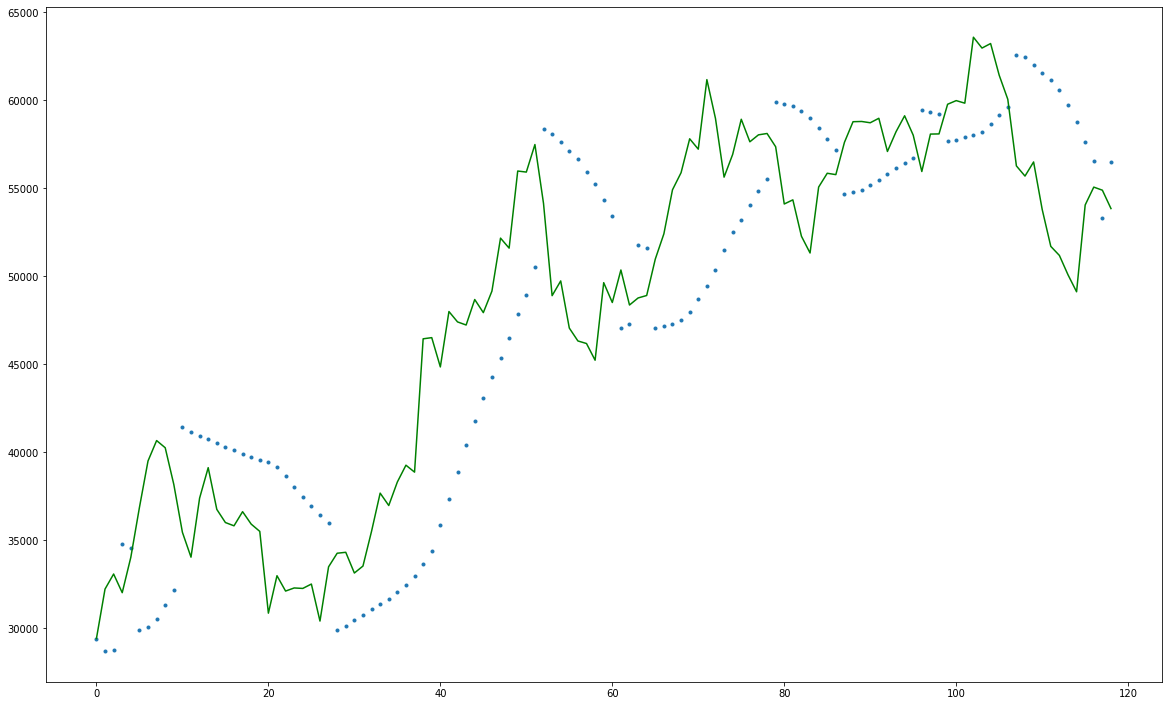

In [68]:
fig, ax = plt.subplots(figsize = [20, 20/1.61])

nPeriodLowWindow = 7
nPeriodHighWindow = 7
accStep = 0.02
accCeil = 0.2

ax.plot(ff.PSAR(dataOriginal['low'].values, dataOriginal['high'].values, dataOriginal['open'].values, dataOriginal['close'].values, nPeriodLowWindow = nPeriodLowWindow, nPeriodHighWindow = nPeriodHighWindow, accStep = accStep, accCeil = accCeil), '.')
ax.plot(dataOriginal['close'].values, color = 'green')        
            

In [24]:
ff.nPeriodHigh(dataOriginal['close'].values)

array([ 6670.85,  6670.85,  6670.85, ..., 55237.57, 55069.62, 55069.62])

## Strategy B - RSI Strategy
buySignal: When RSI-14 crosses 66.66 from below

sellSignal: When RSI-14 crosses 33.33 from above

Customizable parameters:
 - RSI-Period
 - Crossing RSI-Low
 - Crossing RSI-High

In [11]:
data = dataOriginal.copy()
# RSIperiod = 14
# RSILow = 33.33
# RSIHigh = 66.66
RSIperiod = 18
RSILow = 48
RSIHigh = 74
nLimits = np.array([2,len(data)])
%time arrReturn, arrLength, arrPurchased, score, N, parameters = ff.backtestStrategyB(dataOriginal['close'].values, RSIperiod, RSILow, RSIHigh, nLimits)
print("Mean Return: " + str(np.mean(arrReturn)))
print("Mean Daily Return for active periods: " + str(np.mean(arrReturn/arrLength)))
print("Mean Daily Return Overall: " + str((np.prod(1+arrReturn) - 1)/len(arrPurchased)))
print("Mean number of activations per day: " + str(len(arrReturn)/len(arrPurchased)))
print("Strategy Score: " + str(score))

CPU times: user 317 µs, sys: 55 µs, total: 372 µs
Wall time: 350 µs
Mean Return: 0.03912284188099584
Mean Daily Return for active periods: -0.0011698649646837429
Mean Daily Return Overall: 0.0005957507086940739
Mean number of activations per day: 0.012539184952978056
Strategy Score: 9.122863583741779


Text(0.5, 1.0, 'Periods of active and inactive RSI-Strategy for BTC-USD in the last year with optimized values for the parameters.')

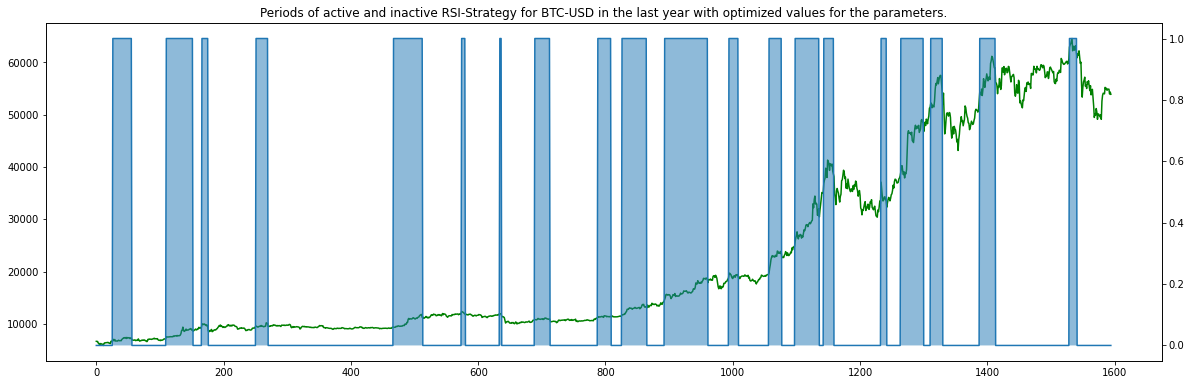

In [12]:
fig, ax = plt.subplots(figsize = [20, 10/1.61])
ax.plot(data['close'].values, color = 'green')
ax2 = ax.twinx()
ax2.plot(arrPurchased)
ax2.fill_between(np.arange(len(arrPurchased)),arrPurchased, alpha = .5)
ax.set_title("Periods of active and inactive RSI-Strategy for BTC-USD in the last year with optimized values for the parameters.")

In [15]:
#Optimizing Strategy B Parameters
RSIperiodVals = np.arange(5,int(0.1*len(dataOriginal)))
RSILowVals = np.arange(20,49)
RSIHighVals = np.arange(51, 80)
#Minimum of one activation every 90 days
minN = int(len(dataOriginal)/90)
#Maximum of one activation per 4 days
maxN = int(len(dataOriginal)/4)
argCombinations = []
for p1 in RSIperiodVals:
    for p2 in RSILowVals:
        for p3 in RSIHighVals:
            argCombinations += [(dataOriginal['close'].values, p1, p2, p3, np.array([minN, maxN], dtype = np.float64))]

with ThreadPoolExecutor(8) as ex:   
    results = ex.map(lambda p: ff.backtestStrategyB(*p), argCombinations)
results = np.array([result for result in results])
results_df = pd.DataFrame(results, columns = ['returns', 'lengths', 'purchasedBool', 'score', 'N', 'parameters'])
results_df = results_df.sort_values(by = 'score')
best = results_df.tail(10).sort_values(by = 'N').iloc[-1]
if best['score'] < 0:
    best['score'] = 0

best.to_dict()['parameters']

<ipython-input-15-fbb4d5691972>:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  results = np.array([result for result in results])


array([ 5, 38, 52])

## Strategy C - OSC (MACD) Strategy
buySignal: When OSC-12-26-9 crosses 0 from below

sellSignal: When OSC-12-26-9 crosses 0 from above

Customizable parameters:
 - OSC-Period1
 - OSC-Period2
 - OSC-Period3
 - Crossing OSC-Low
 - Crossing OSC-High

In [14]:
data = dataOriginal.copy()
# OSCPeriod1 = 12
# OSCPeriod2 = 26
# OSCPeriod3 = 9
# OSCLow = 0
# OSCHigh = 0
        
OSCPeriod1 = 1.20000000e+01
OSCPeriod2 = 2.40000000e+01
OSCPeriod3 = 7.00000000e+00
OSCLow = -4.44444444e-04
OSCHigh = -1.66666667e-04

%time arrReturn, arrLength, arrPurchased, score, N, parameters = ff.backtestStrategyC(dataOriginal['close'].values, OSCPeriod1, OSCPeriod2, OSCPeriod3, OSCLow, OSCHigh, nLimits)
print("Mean Return: " + str(np.mean(arrReturn)))
print("Mean Daily Return for active periods: " + str(np.mean(arrReturn/arrLength)))
print("Mean Daily Return Overall: " + str((np.prod(1+arrReturn) - 1)/len(arrPurchased)))
print("Mean number of activations per day: " + str(len(arrReturn)/len(arrPurchased)))
print("Strategy Score: " + str(score))

CPU times: user 219 µs, sys: 23 µs, total: 242 µs
Wall time: 247 µs
Mean Return: 0.041275856371246734
Mean Daily Return for active periods: 0.0006112063285998886
Mean Daily Return Overall: 0.00570355638130022
Mean number of activations per day: 0.03761755485893417
Strategy Score: 0.6272835553221435


Text(0.5, 1.0, 'Periods of active and inactive OSC-Strategy for BTC-USD in the last year with optimized values for the parameters.')

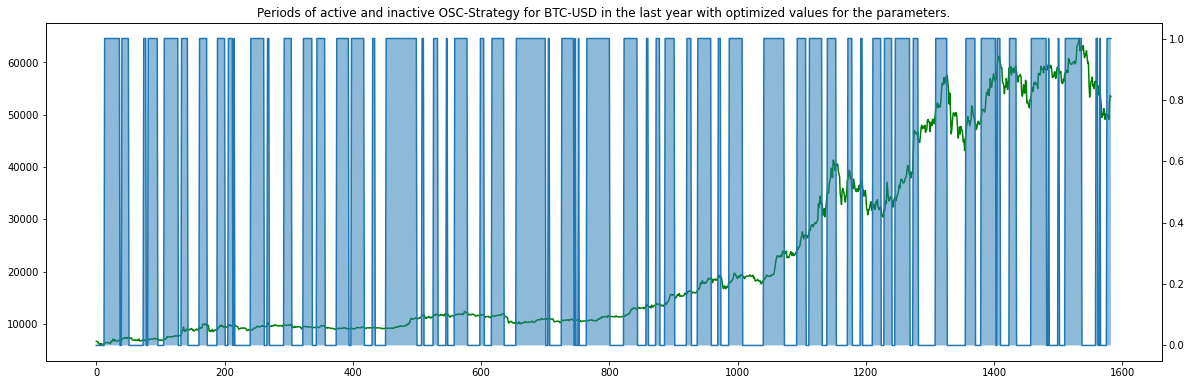

In [411]:
fig, ax = plt.subplots(figsize = [20, 10/1.61])
ax.plot(data['close'].values, color = 'green')
ax2 = ax.twinx()
ax2.plot(arrPurchased)
ax2.fill_between(np.arange(len(arrPurchased)),arrPurchased, alpha = .5)
ax.set_title("Periods of active and inactive OSC-Strategy for BTC-USD in the last year with optimized values for the parameters.")

In [16]:
#Optimizing Strategy A Parameters
OSCperiod1Vals = np.arange(10,40)
OSCperiod2Vals = np.arange(20,50)
OSCperiod3Vals = np.arange(7,20)

OSCLowVals = np.linspace(-0.001, 0.0015, num = 10)
OSCHighVals = np.linspace(-0.001, 0.0015, num = 10)
#Minimum of one activation every 90 days
minN = int(len(dataOriginal)/90)
#Maximum of one activation per 4 days
maxN = int(len(dataOriginal)/4)
argCombinations = []
for p1 in OSCperiod1Vals:
    for p2 in OSCperiod2Vals:
        for p3 in OSCperiod3Vals:
            for p4 in OSCLowVals:
                for p5 in OSCHighVals:
                    if p2 > p1 > p3 and p5 > p4:
                        argCombinations += [(dataOriginal['close'].values, p1, p2, p3, p4, p5, np.array([minN, maxN], dtype = np.float64))]
                        
with ThreadPoolExecutor(8) as ex:   
    results = ex.map(lambda p: ff.backtestStrategyC(*p), argCombinations)
results = np.array([result for result in results])
results_df = pd.DataFrame(results, columns = ['returns', 'lengths', 'purchasedBool', 'score', 'N', 'parameters'])
results_df = results_df.sort_values(by = 'score')
best = results_df.tail(10).sort_values(by = 'N').iloc[-1]
if best['score'] < 0:
    best['score'] = 0
best.to_dict()['parameters']

<ipython-input-16-f1936de968f0>:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  results = np.array([result for result in results])


array([1.90000000e+01, 2.40000000e+01, 1.70000000e+01, 3.88888889e-04,
       1.50000000e-03])

## Strategy D
buySignal: 

SellSignal: 

In [34]:
start = datetime.datetime(2016,3,27)
end = datetime.datetime.now()
granularity = 24*60*60
allCloseData = np.array([cf.getData(Client, asset, start, end, granularity = granularity)['close'].values for asset in assets])
clear_output()


In [35]:
parameters = []
scores = []
for asset in assets:
    with open(cf.dbPath + "/" + asset + "/StrAParams_" + str(granularity) + ".pkl", 'rb') as f:
        best = pkl.load(f)
        parameters += [best['parameters']]
        scores += [best['score']]
parameters = np.array(parameters)
nLims = np.array([2,max([len(data) for data in allCloseData])])
currentScoreA = np.array([ff.backtestStrategyA(allCloseData[i], parameters[i][0], parameters[i][1], parameters[i][2], nLims)[2][-1]*scores[i] for i in range(len(allCloseData))])


In [36]:
parameters = []
scores = []
for asset in assets:
    with open(cf.dbPath + "/" + asset + "/StrBParams_" + str(granularity) + ".pkl", 'rb') as f:
        best = pkl.load(f)
        parameters += [best['parameters']]
        scores += [best['score']]
parameters = np.array(parameters)
nLims = np.array([2,max([len(data) for data in allCloseData])])
currentScoreB = np.array([ff.backtestStrategyB(allCloseData[i], parameters[i][0], parameters[i][1], parameters[i][2], nLims)[2][-1]*scores[i] for i in range(len(allCloseData))])


In [37]:
parameters = []
scores = []
for asset in assets:
    with open(cf.dbPath + "/" + asset + "/StrCParams_" + str(granularity) + ".pkl", 'rb') as f:
        best = pkl.load(f)
        parameters += [best['parameters']]
        scores += [best['score']]
parameters = np.array(parameters)
nLims = np.array([2,max([len(data) for data in allCloseData])])
currentScoreC = np.array([ff.backtestStrategyC(allCloseData[i], parameters[i][0], parameters[i][1], parameters[i][2], parameters[i][3], parameters[i][4], nLims)[2][-1]*scores[i] for i in range(len(allCloseData))])

In [38]:
totalScores = currentScoreA + currentScoreB + currentScoreC
#USD score is 1/2 the mean score
totalScores = np.append(totalScores, [0.5*np.mean(totalScores)])
portfolioWeights = totalScores/sum(totalScores)
portfolio86400 = {(assets + ['USD-USD'])[i]:portfolioWeights[i] for i in range(len(assets + ['USD-USD']))}

In [ ]:
start = datetime.datetime(2016,3,27)
end = datetime.datetime.now()
granularity = 6*60*60
allCloseData = np.array([cf.getData(Client, asset, start, end, granularity = granularity, verbose = False)['close'].values for asset in assets])
clear_output()

In [ ]:
parameters = []
scores = []
for asset in assets:
    with open(cf.dbPath + "/" + asset + "/StrAParams_" + str(granularity) + ".pkl", 'rb') as f:
        best = pkl.load(f)
        parameters += [best['parameters']]
        scores += [best['score']]
parameters = np.array(parameters)
nLims = np.array([2,max([len(data) for data in allCloseData])])
currentScoreA = np.array([ff.backtestStrategyA(allCloseData[i], parameters[i][0], parameters[i][1], parameters[i][2], nLims)[2][-1]*scores[i] for i in range(len(allCloseData))])

In [ ]:
parameters = []
scores = []
for asset in assets:
    with open(cf.dbPath + "/" + asset + "/StrBParams_" + str(granularity) + ".pkl", 'rb') as f:
        best = pkl.load(f)
        parameters += [best['parameters']]
        scores += [best['score']]
parameters = np.array(parameters)
nLims = np.array([2,max([len(data) for data in allCloseData])])
currentScoreB = np.array([ff.backtestStrategyB(allCloseData[i], parameters[i][0], parameters[i][1], parameters[i][2], nLims)[2][-1]*scores[i] for i in range(len(allCloseData))])


In [ ]:
parameters = []
scores = []
for asset in assets:
    with open(cf.dbPath + "/" + asset + "/StrCParams_" + str(granularity) + ".pkl", 'rb') as f:
        best = pkl.load(f)
        parameters += [best['parameters']]
        scores += [best['score']]
parameters = np.array(parameters)
nLims = np.array([2,max([len(data) for data in allCloseData])])
currentScoreC = np.array([ff.backtestStrategyC(allCloseData[i], parameters[i][0], parameters[i][1], parameters[i][2], parameters[i][3], parameters[i][4], nLims)[2][-1]*scores[i] for i in range(len(allCloseData))])


In [ ]:
totalScores = currentScoreA + currentScoreB + currentScoreC
#USD score is 1/2 the mean score
totalScores = np.append(totalScores, [0.5*np.mean(totalScores)])
portfolioWeights = totalScores/sum(totalScores)
portfolio21600 = {(assets + ['USD-USD'])[i]:portfolioWeights[i] for i in range(len(assets + ['USD-USD']))}


In [ ]:
start = datetime.datetime(2016,3,27)
end = datetime.datetime.now()
granularity = 60*60
allCloseData = np.array([cf.getData(Client, asset, start, end, granularity = granularity, verbose = False)['close'].values for asset in assets])
clear_output()

In [ ]:
parameters = []
scores = []
for asset in assets:
    with open(cf.dbPath + "/" + asset + "/StrAParams_" + str(granularity) + ".pkl", 'rb') as f:
        best = pkl.load(f)
        parameters += [best['parameters']]
        scores += [best['score']]
parameters = np.array(parameters)
nLims = np.array([2,max([len(data) for data in allCloseData])])
currentScoreA = np.array([ff.backtestStrategyA(allCloseData[i], parameters[i][0], parameters[i][1], parameters[i][2], nLims)[2][-1]*scores[i] for i in range(len(allCloseData))])

In [ ]:

parameters = []
scores = []
for asset in assets:
    with open(cf.dbPath + "/" + asset + "/StrBParams_" + str(granularity) + ".pkl", 'rb') as f:
        best = pkl.load(f)
        parameters += [best['parameters']]
        scores += [best['score']]
parameters = np.array(parameters)
nLims = np.array([2,max([len(data) for data in allCloseData])])
currentScoreB = np.array([ff.backtestStrategyB(allCloseData[i], parameters[i][0], parameters[i][1], parameters[i][2], nLims)[2][-1]*scores[i] for i in range(len(allCloseData))])

In [ ]:
parameters = []
scores = []
for asset in assets:
    with open(cf.dbPath + "/" + asset + "/StrCParams_" + str(granularity) + ".pkl", 'rb') as f:
        best = pkl.load(f)
        parameters += [best['parameters']]
        scores += [best['score']]
parameters = np.array(parameters)
nLims = np.array([2,max([len(data) for data in allCloseData])])
currentScoreC = np.array([ff.backtestStrategyC(allCloseData[i], parameters[i][0], parameters[i][1], parameters[i][2], parameters[i][3], parameters[i][4], nLims)[2][-1]*scores[i] for i in range(len(allCloseData))])



In [ ]:
totalScores = currentScoreA + currentScoreB + currentScoreC
#USD score is 1/2 the mean score
totalScores = np.append(totalScores, [0.5*np.mean(totalScores)])
portfolioWeights = totalScores/sum(totalScores)
portfolio3600 = {(assets + ['USD-USD'])[i]:portfolioWeights[i] for i in range(len(assets + ['USD-USD']))}


In [ ]:
finalPortfolio = {key:(portfolio3600[key] + portfolio21600[key] + portfolio86400[key])/3 for key in portfolio3600.keys()}


In [40]:
for granularity in [24*60*60, 6*60*60, 60*60]:
    for asset in assets[1:]:
        clear_output()
        print(asset + " - " + str(granularity))
        cf.updateData(Client, asset, granularity, verbose = False)

ZRX-USD - 3600
Retrieving data for ZRX-USD

Retrieving data for ZRX-USD
Failure in retreiving data for ZRX-USD. Waiting 1 second and trying again. 1/10
{'message': 'Public rate limit exceeded'}


In [67]:
hist = pd.read_csv("/home/andrerg01/AutoTraders/fredinhouTradingBot/Coinbase_Trader_4.0/logs/hist.csv", parse_dates=['Date'], converters = {'Portfolio': eval}).set_index('Date')

In [4]:
hist

,Funds,Portfolio,Rebalance,Buys,Sells
Date,,,,,
2021-03-25 15:19:06.451740,99.585425,"{'AAVE-USD': 0.0, 'ADA-USD': 0.0, 'ALGO-USD': ...",0.0,{},{}
2021-03-25 15:34:12.675508,99.908841,"{'AAVE-USD': 0.0, 'ADA-USD': 0.0, 'ALGO-USD': ...",0.0,{},{}
2021-03-25 15:47:29.364564,99.908841,"{'AAVE-USD': 0.0, 'ADA-USD': 0.0, 'ALGO-USD': ...",0.0,{},{}
2021-03-25 16:41:24.426234,99.759576,"{'AAVE-USD': 0.0, 'ADA-USD': 0.0, 'ALGO-USD': ...",0.0,{},{}
2021-03-25 17:48:13.093859,100.789031,"{'AAVE-USD': 0.0, 'ADA-USD': 0.0, 'ALGO-USD': ...",0.0,{},{}
...,...,...,...,...,...
2021-04-16 19:02:30.621819,150.677989,"{'AAVE-USD': 0.14677635692179242, 'ADA-USD': 0...",0.0,"{'FIL-USD': 0.04715085412654737, 'NMR-USD': 0....","{'AAVE-USD': 0.009659760192524115, 'ADA-USD': ..."
2021-04-16 20:01:57.597479,149.579952,"{'AAVE-USD': 0.1467428938557484, 'ADA-USD': 0....",0.0,"{'ALGO-USD': 0.7175858840846903, 'REN-USD': 0....","{'AAVE-USD': 0.009814294170962112, 'ADA-USD': ..."
2021-04-16 21:01:27.274083,151.107099,"{'AAVE-USD': 0.11714356098505033, 'ADA-USD': 0...",0.0,"{'ALGO-USD': 0.6478701813551094, 'REN-USD': 0....","{'AAVE-USD': 0.010247281441605825, 'ADA-USD': ..."


In [107]:
def makePricePlot(hist, ax):
    ax.plot(hist['Funds'], label = 'Total Funds', color = 'green')
    ax.set_xlabel("Date")
    ax.set_ylabel("Total Funds (USD)")
    ax.set_title("Funds History")
    ax.grid()
    
def makeTimePortfolioPlot(hist, ax):
    everInvestedAssets = []
    for port in hist['Portfolio']:
        for key in port.keys():
            if port[key] > 0 and key not in everInvestedAssets:
                everInvestedAssets += [key]
    assetInvestOverTime = {asset:[] for asset in everInvestedAssets}
    for port in hist['Portfolio']:
        for asset in everInvestedAssets:
            if asset in port.keys():
                assetInvestOverTime[asset] += [port[asset]]
            else:
                assetInvestOverTime[asset] += [0]
    for asset in everInvestedAssets:
        ax.plot(hist.index, assetInvestOverTime[asset], label = asset)
    ax.legend(title='Asset', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_title('Asset share in portfolio over time.')
    ax.set_xlabel("Date")
    ax.set_ylabel("Portfolio share")
    ax.grid()
    
def makeTimePortfolioPlot(hist, ax):
    boxProps = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    everInvestedAssets = []
    for port in hist['Portfolio']:
        for key in port.keys():
            if port[key] > 0 and key not in everInvestedAssets:
                everInvestedAssets += [key]
    assetInvestOverTime = {asset:[] for asset in everInvestedAssets}
    for port in hist['Portfolio']:
        for asset in everInvestedAssets:
            if asset in port.keys():
                assetInvestOverTime[asset] += [port[asset]]
            else:
                assetInvestOverTime[asset] += [0]
    for i in range(len(everInvestedAssets)):
        if i == 0:
            y1 = assetInvestOverTime[everInvestedAssets[i]]
            ax.fill_between(hist.index, y1)
            if assetInvestOverTime[everInvestedAssets[i]][-1] > 0.01:
                x = hist.index[-1]
                y = assetInvestOverTime[everInvestedAssets[i]][-1]/2
                ax.text(x, y, everInvestedAssets[i], bbox = boxProps)
        else:
            y1 = assetInvestOverTime[everInvestedAssets[i]] + sum([np.array(assetInvestOverTime[everInvestedAssets[j]]) for j in range(i)])
            y2 = sum([np.array(assetInvestOverTime[everInvestedAssets[j]]) for j in range(i)])
            ax.fill_between(hist.index, y1, y2, where = y1 > y2, interpolate = True)
            if assetInvestOverTime[everInvestedAssets[i]][-1] > 0.01:
                x = hist.index[-1]
                y = assetInvestOverTime[everInvestedAssets[i]][-1]/2 + sum([np.array(assetInvestOverTime[everInvestedAssets[j]]) for j in range(i)])[-1]
                ax.text(x, y, everInvestedAssets[i], bbox = boxProps)
    ax.set_title('Asset share in portfolio over time.')
    ax.set_xlabel("Date")
    ax.set_ylabel("Portfolio share")
    ax.grid() 

def makeCurrentPortfolioPlot(hist, ax):
    everInvestedAssets = []
    for port in hist['Portfolio']:
        for key in port.keys():
            if port[key] > 0 and key not in everInvestedAssets:
                everInvestedAssets += [key]
    heights = [hist.iloc[-1]['Portfolio'][asset] for asset in hist.iloc[-1]['Portfolio'].keys()]
    ax.bar([asset[:3] for asset in hist.iloc[-1]['Portfolio'].keys()], heights)
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    ax.set_xlabel("Asset")
    ax.set_ylabel("Share in current portfolio")
    ax.set_title("Layout of current portfolio")
    ax.grid()

def makeMarketPerformancePlot(allCloseRelevant, hist, ax):
    equalWeightFunds = [1 for _ in range(len(allCloseRelevant[0]))]
    
    equalWeightReturns = [0 for _ in range(len(allCloseRelevant[0]))]
    for i in range(len(allCloseRelevant)):
        for j in range(1, len(allCloseRelevant[i])):
            equalWeightReturns[j] = (allCloseRelevant[i][j] - allCloseRelevant[i][j-1])/allCloseRelevant[i][j-1]/len(allCloseRelevant)
            equalWeightFunds[j] = equalWeightFunds[j-1]*(1+equalWeightReturns[j])
    ax.plot(equalWeightFunds, '--', color = 'blue', label = 'Equally Weighted Backtest')    
    ax.set_title("Market Performance")
    ax.set_ylabel("Equally Weighted Portfolio Funds")
    ax.set_xlabel("Periods")
    ax.legend(loc='upper left')
    ax.grid()
#ax.set_yscale('log')

    


In [560]:
end = datetime.datetime.now()
allData = [cf.getData(Client, asset, start, end, 60*60, verbose = False) for asset in assets]
clear_output()

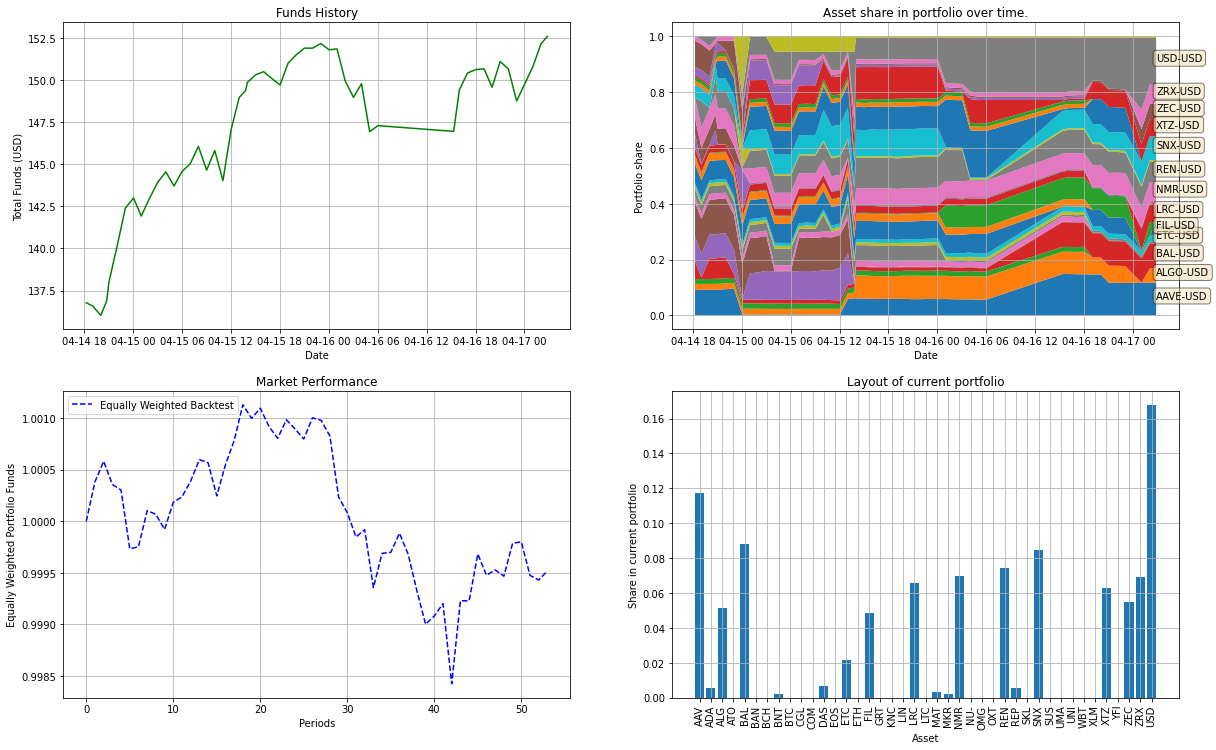

In [108]:
fig, ax = plt.subplots(2, 2, figsize = [20,20/1.61])
#histTemp = hist[datetime.datetime(2021, 4, 13):]
histTemp = hist[datetime.datetime.now() - datetime.timedelta(days = 7):].copy()
makePricePlot(histTemp, ax[0, 0])
makeTimePortfolioPlot(histTemp, ax[0, 1])
makeMarketPerformancePlot([d[histTemp.index[0]:]['close'].values for d in allData], histTemp, ax[1, 0])
makeCurrentPortfolioPlot(histTemp, ax[1, 1])
#fig.tight_layout()

## Backtest Multi-Asset Strategy A

### 86400

In [582]:
backtestDateStart = datetime.datetime(2019,1,1)
backtestDateEnd = datetime.datetime(2020,1,1)
#backtestDateEnd = datetime.datetime.now()
granularity = 60*60*24
nOfDays = int((backtestDateEnd - backtestDateStart).total_seconds()/datetime.timedelta(seconds = granularity).total_seconds()+1)
backtestDateCurrent = backtestDateStart
allData86400 = [cf.getData(Client, asset, start, backtestDateEnd, granularity, verbose = False) for asset in assets]
tradeFee = 0.005
clear_output()

In [510]:
goodAllData86400 = []
goodAssets = []
goodAllCloseData86400 = []
for i in range(len(assets)):
    if len(allData86400[i][backtestDateStart:backtestDateEnd]) == nOfDays and allData86400[i][backtestDateStart:].index[0] == backtestDateStart:
        goodAllData86400 += [allData86400[i][backtestDateStart:backtestDateEnd]]
        goodAllCloseData86400 += [allData86400[i][backtestDateStart:backtestDateEnd]['close'].values]
        goodAssets += [assets[i]]
fullTimeScore = []

scoreHist = []
for i in range(len(goodAssets)):
    with open(cf.dbPath + "/" + goodAssets[i] + "/Str" + 'A' + "Params_" + str(granularity) + ".pkl", 'rb') as f:
        best = pkl.load(f)
        parameters = best['parameters']
        score = best['score']
    nLims = np.array([2,max([len(data) for data in goodAllCloseData86400])])
    scoreHist += [ff.backtestStrategyA(goodAllCloseData86400[i], parameters[0], parameters[1], parameters[2], nLims)[2]*score]
currentPortfolioSize = {(goodAssets + ['USD-USD'])[i]:0 for i in range(len(goodAssets + ['USD-USD']))}
currentPortfolioSize['USD-USD'] = 100
totalFunds = 100
fundsHist = []
for i in range(len(scoreHist[0])):
    currentPrices = {goodAssets[j]:goodAllCloseData86400[j][i] for j in range(len(goodAssets))}
    currentPrices['USD-USD'] = 1
    totalFunds = sum([currentPortfolioSize[key]*currentPrices[key] for key in currentPrices.keys()])
    
    goalPortfolio = {goodAssets[j]:scoreHist[j][i] for j in range(len(goodAssets))}
    goalPortfolio['USD-USD'] = 0.000001
    goalPortfolio = ff.nicefyPortfolio(goalPortfolio, 0.00)
    
    goalPortfolioSize = {key:goalPortfolio[key]*totalFunds/currentPrices[key] for key in currentPrices.keys()}
    
    trades = {key: abs(currentPortfolioSize[key] - goalPortfolioSize[key]) for key in goalPortfolioSize.keys()}
    
    currentPortfolioSize = goalPortfolioSize
    
    currentPortfolioSize = {key:currentPortfolioSize[key] - trades[key]*tradeFee for key in currentPortfolioSize.keys()}

    fundsHist += [totalFunds]

returnsHist = np.array(ff.returns(np.array(fundsHist)))
intReturns = (np.prod(1 + returnsHist[1:]) - 1)**(30/len(returnsHist[1:]))
intVol = np.std(returnsHist[1:])*np.sqrt(30)
print("Intervalized Returns: " + str(intReturns))
print("Intervalized Volatility: " + str(intVol))
print("Intervalized SharpeRatio: " + str(intReturns/intVol))


Intervalized Returns: 1.0050584901100201
Intervalized Volatility: 0.21223157290160194
Intervalized SharpeRatio: 4.735669044756129


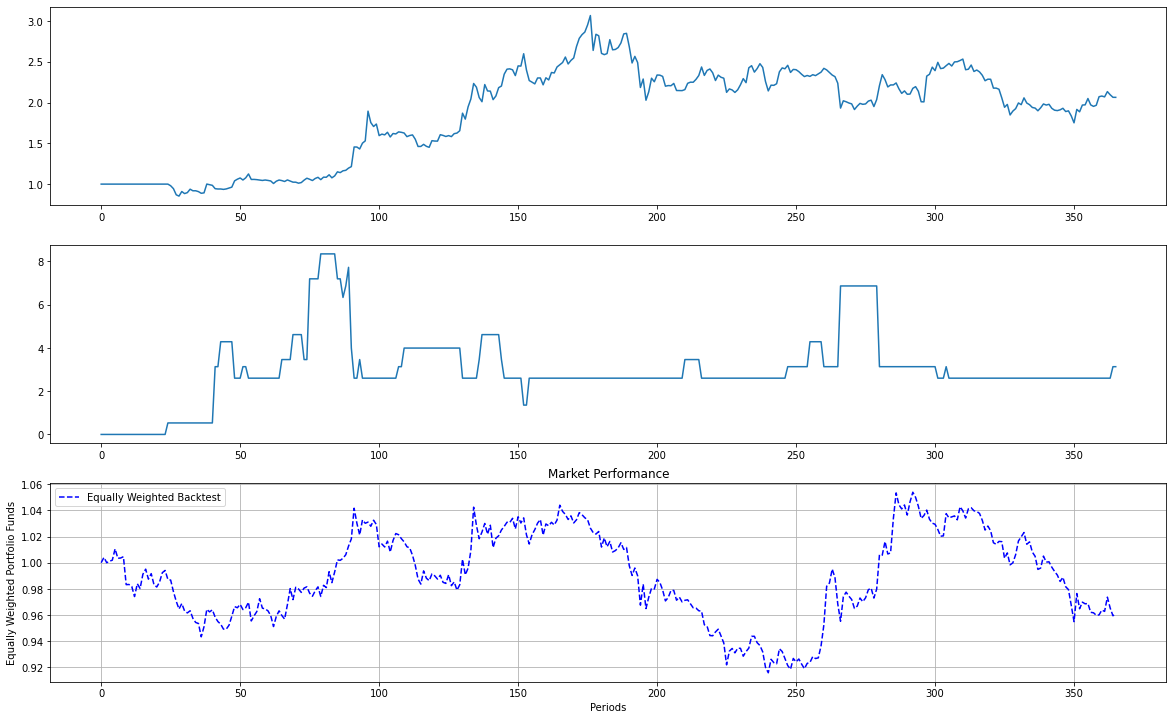

In [511]:
fig, ax = plt.subplots(3, figsize = [20,20/1.61])
ax[0].plot(np.array(fundsHist)/100)
ax[1].plot(sum([np.array(scoreHist[i]) for i in range(len(scoreHist))]))
#ax[1].plot(scoreHist[1])
ff.makeMarketPerformancePlot(goodAllCloseData86400, ax[2])

## Backtest Multi-Asset Strategy B

In [512]:
goodAllData86400 = []
goodAssets = []
goodAllCloseData86400 = []
for i in range(len(assets)):
    if len(allData86400[i][backtestDateStart:backtestDateEnd]) == nOfDays and allData86400[i][backtestDateStart:].index[0] == backtestDateStart:
        goodAllData86400 += [allData86400[i][backtestDateStart:backtestDateEnd]]
        goodAllCloseData86400 += [allData86400[i][backtestDateStart:backtestDateEnd]['close'].values]
        goodAssets += [assets[i]]
fullTimeScore = []

scoreHist = []
for i in range(len(goodAssets)):
    with open(cf.dbPath + "/" + goodAssets[i] + "/Str" + 'B' + "Params_" + str(granularity) + ".pkl", 'rb') as f:
        best = pkl.load(f)
        parameters = best['parameters']
        score = best['score']
    nLims = np.array([2,max([len(data) for data in goodAllCloseData86400])])
    scoreHist += [ff.backtestStrategyB(goodAllCloseData86400[i], parameters[0], parameters[1], parameters[2], nLims)[2]*score]
currentPortfolioSize = {(goodAssets + ['USD-USD'])[i]:0 for i in range(len(goodAssets + ['USD-USD']))}
currentPortfolioSize['USD-USD'] = 100
totalFunds = 100
fundsHist = []
for i in range(len(scoreHist[0])):
    currentPrices = {goodAssets[j]:goodAllCloseData86400[j][i] for j in range(len(goodAssets))}
    currentPrices['USD-USD'] = 1
    totalFunds = sum([currentPortfolioSize[key]*currentPrices[key] for key in currentPrices.keys()])
    
    goalPortfolio = {goodAssets[j]:scoreHist[j][i] for j in range(len(goodAssets))}
    goalPortfolio['USD-USD'] = 0.000001
    goalPortfolio = ff.nicefyPortfolio(goalPortfolio, 0.00)
    
    goalPortfolioSize = {key:goalPortfolio[key]*totalFunds/currentPrices[key] for key in currentPrices.keys()}
            
    trades = {key: abs(currentPortfolioSize[key] - goalPortfolioSize[key]) for key in goalPortfolioSize.keys()}
    
    currentPortfolioSize = goalPortfolioSize
    
    currentPortfolioSize = {key:currentPortfolioSize[key] - trades[key]*tradeFee for key in currentPortfolioSize.keys()}

    fundsHist += [totalFunds]
returnsHist = np.array(ff.returns(np.array(fundsHist)))
intReturns = (np.prod(1 + returnsHist[1:]) - 1)**(30/len(returnsHist[1:]))
intVol = np.std(returnsHist[1:])*np.sqrt(30)
print("Intervalized Returns: " + str(intReturns))
print("Intervalized Volatility: " + str(intVol))
print("Intervalized SharpeRatio: " + str(intReturns/intVol))



Intervalized Returns: 1.1312859958776955
Intervalized Volatility: 0.2179818532559861
Intervalized SharpeRatio: 5.189817312678659


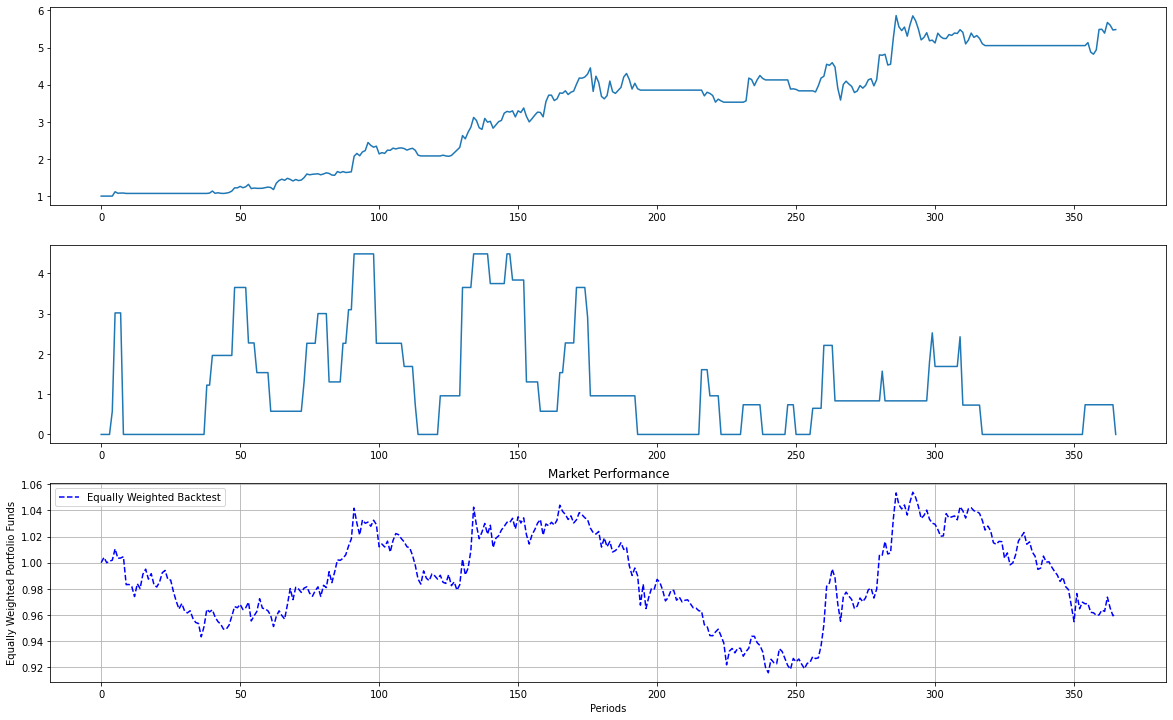

In [491]:
fig, ax = plt.subplots(3, figsize = [20,20/1.61])
ax[0].plot(np.array(fundsHist)/100)
ax[1].plot(sum([np.array(scoreHist[i]) for i in range(len(scoreHist))]))
#ax[1].plot(scoreHist[1])
ff.makeMarketPerformancePlot(goodAllCloseData86400, ax[2])

## Backtest Multi-Asset Strategy C

In [515]:
goodAllData86400 = []
goodAssets = []
goodAllCloseData86400 = []
for i in range(len(assets)):
    if len(allData86400[i][backtestDateStart:backtestDateEnd]) == nOfDays and allData86400[i][backtestDateStart:].index[0] == backtestDateStart:
        goodAllData86400 += [allData86400[i][backtestDateStart:backtestDateEnd]]
        goodAllCloseData86400 += [allData86400[i][backtestDateStart:backtestDateEnd]['close'].values]
        goodAssets += [assets[i]]
fullTimeScore = []

scoreHist = []
for i in range(len(goodAssets)):
    with open(cf.dbPath + "/" + goodAssets[i] + "/Str" + 'C' + "Params_" + str(granularity) + ".pkl", 'rb') as f:
        best = pkl.load(f)
        parameters = best['parameters']
        score = best['score']
    nLims = np.array([2,max([len(data) for data in goodAllCloseData86400])])
    scoreHist += [ff.backtestStrategyC(goodAllCloseData86400[i], parameters[0], parameters[1], parameters[2], parameters[3], parameters[4], nLims)[2]*score]
currentPortfolioSize = {(goodAssets + ['USD-USD'])[i]:0 for i in range(len(goodAssets + ['USD-USD']))}
currentPortfolioSize['USD-USD'] = 100
totalFunds = 100
fundsHist = []
for i in range(len(scoreHist[0])):
    currentPrices = {goodAssets[j]:goodAllCloseData86400[j][i] for j in range(len(goodAssets))}
    currentPrices['USD-USD'] = 1
    totalFunds = sum([currentPortfolioSize[key]*currentPrices[key] for key in currentPrices.keys()])
    
    goalPortfolio = {goodAssets[j]:scoreHist[j][i] for j in range(len(goodAssets))}
    goalPortfolio['USD-USD'] = 0.000001
    goalPortfolio = ff.nicefyPortfolio(goalPortfolio, 0.00)
    
    goalPortfolioSize = {key:goalPortfolio[key]*totalFunds/currentPrices[key] for key in currentPrices.keys()}
            
    trades = {key: abs(currentPortfolioSize[key] - goalPortfolioSize[key]) for key in goalPortfolioSize.keys()}
    
    currentPortfolioSize = goalPortfolioSize
    
    currentPortfolioSize = {key:currentPortfolioSize[key] - trades[key]*tradeFee for key in currentPortfolioSize.keys()}

    fundsHist += [totalFunds]
returnsHist = np.array(ff.returns(np.array(fundsHist)))
intReturns = (np.prod(1 + returnsHist[1:]) - 1)**(30/len(returnsHist[1:]))
intVol = np.std(returnsHist[1:])*np.sqrt(30)
SR = intReturns/intVol
print("Intervalized Returns: " + str(intReturns))
print("Intervalized Volatility: " + str(intVol))
print("Intervalized SharpeRatio: " + str(SR))



Intervalized Returns: 1.008117482192635
Intervalized Volatility: 0.1882780815945847
Intervalized SharpeRatio: 5.354407022073836


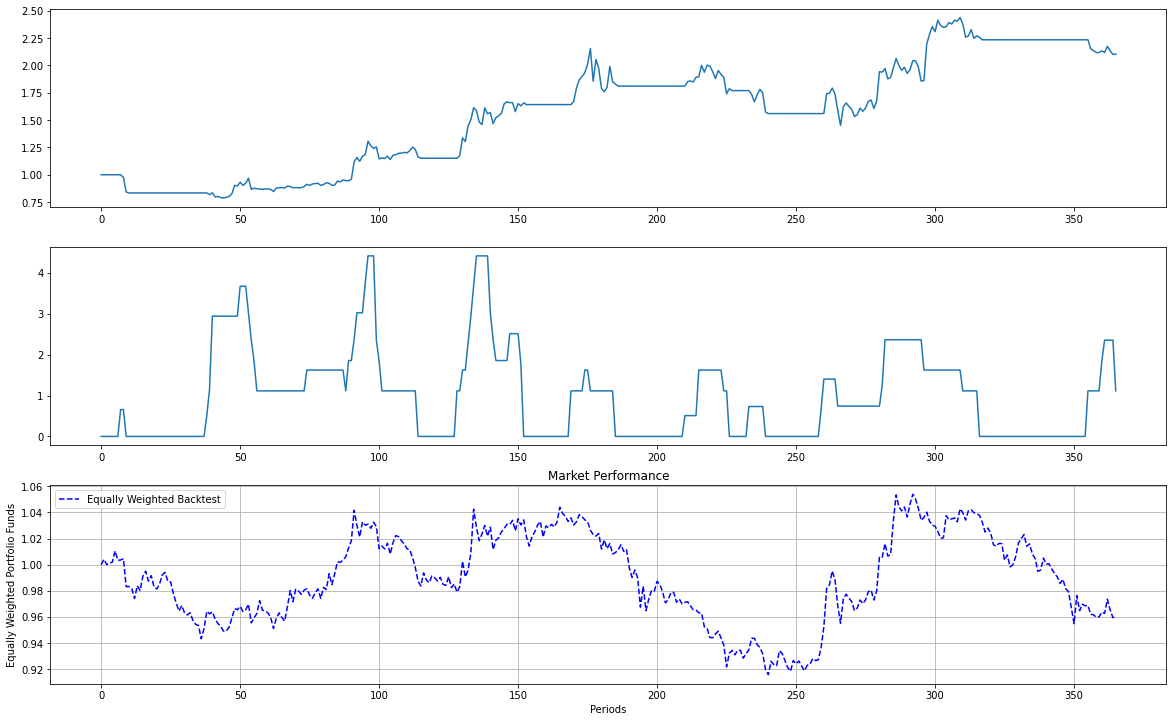

In [514]:
fig, ax = plt.subplots(3, figsize = [20,20/1.61])
ax[0].plot(np.array(fundsHist)/100)
ax[1].plot(sum([np.array(scoreHist[i]) for i in range(len(scoreHist))]))
#ax[1].plot(scoreHist[1])
ff.makeMarketPerformancePlot(goodAllCloseData86400, ax[2])

## Backtest Multi-Asset Strategy A & B & C

In [785]:
goodAllData86400 = []
goodAssets = []
goodAllCloseData86400 = []
for i in range(len(assets)):
    if len(allData86400[i][backtestDateStart:backtestDateEnd]) == nOfDays and allData86400[i][backtestDateStart:].index[0] == backtestDateStart:
        goodAllData86400 += [allData86400[i][backtestDateStart:backtestDateEnd]]
        goodAllCloseData86400 += [allData86400[i][backtestDateStart:backtestDateEnd]['close'].values]
        goodAssets += [assets[i]]
fullTimeScore = []

scoreHistA = []
for i in range(len(goodAssets)):
    with open(cf.dbPath + "/" + goodAssets[i] + "/Str" + 'A' + "Params_" + str(granularity) + ".pkl", 'rb') as f:
        best = pkl.load(f)
        parameters = best['parameters']
        score = best['score']
    nLims = np.array([2,max([len(data) for data in goodAllCloseData86400])])
    scoreHistA += [ff.backtestStrategyA(goodAllCloseData86400[i], parameters[0], parameters[1], parameters[2], nLims)[2]*score]
scoreHistB = []
for i in range(len(goodAssets)):
    with open(cf.dbPath + "/" + goodAssets[i] + "/Str" + 'B' + "Params_" + str(granularity) + ".pkl", 'rb') as f:
        best = pkl.load(f)
        parameters = best['parameters']
        score = best['score']
    nLims = np.array([2,max([len(data) for data in goodAllCloseData86400])])
    scoreHistB += [ff.backtestStrategyB(goodAllCloseData86400[i], parameters[0], parameters[1], parameters[2], nLims)[2]*score]
     
scoreHistC = []
for i in range(len(goodAssets)):
    with open(cf.dbPath + "/" + goodAssets[i] + "/Str" + 'C' + "Params_" + str(granularity) + ".pkl", 'rb') as f:
        best = pkl.load(f)
        parameters = best['parameters']
        score = best['score']
    nLims = np.array([2,max([len(data) for data in goodAllCloseData86400])])
    scoreHistC += [ff.backtestStrategyC(goodAllCloseData86400[i], parameters[0], parameters[1], parameters[2], parameters[3], parameters[4], nLims)[2]*score]


scoreHist = [[0 for j in range(len(scoreHistB[0]))] for i in range(len(scoreHistB))]
for i in range(len(scoreHistB)):
    for j in range(len(scoreHistB[i])):
        if scoreHistB[i][j] > 0 and scoreHistC[i][j] > 0:
            scoreHist[i][j] = scoreHistB[i][j] + scoreHistC[i][j]

currentPortfolioSize = {(goodAssets + ['USD-USD'])[i]:0 for i in range(len(goodAssets + ['USD-USD']))}
currentPortfolioSize['USD-USD'] = 100
totalFunds = 100
fundsHist = []
for i in range(len(scoreHist[0])):
    currentPrices = {goodAssets[j]:goodAllCloseData86400[j][i] for j in range(len(goodAssets))}
    currentPrices['USD-USD'] = 1
    totalFunds = sum([currentPortfolioSize[key]*currentPrices[key] for key in currentPrices.keys()])

    goalPortfolio = {goodAssets[j]:scoreHist[j][i] for j in range(len(goodAssets))}
    #goalPortfolio['USD-USD'] = 0.0001
    scoresNow = np.array([goalPortfolio[key] for key in goalPortfolio.keys()])
    scoresNow = list(scoresNow[scoresNow > 0])
    goalPortfolio['USD-USD'] = np.percentile(scoresNow + [0.0001], 50)
    goalPortfolio = ff.nicefyPortfolio(goalPortfolio, 0.00)

    goalPortfolioSize = {key:goalPortfolio[key]*totalFunds/currentPrices[key] for key in currentPrices.keys()}

    trades = {key: abs(currentPortfolioSize[key] - goalPortfolioSize[key]) for key in goalPortfolioSize.keys()}

    currentPortfolioSize = goalPortfolioSize

    currentPortfolioSize = {key:currentPortfolioSize[key] - trades[key]*tradeFee for key in currentPortfolioSize.keys()}

    fundsHist += [totalFunds]

returnsHist = np.array(ff.returns(np.array(fundsHist)))
intReturns = (np.prod(1 + returnsHist[1:]) - 1)**(30/len(returnsHist[1:]))
intVol = np.std(returnsHist[1:])*np.sqrt(30)
SR = intReturns/intVol
print("Monthly Returns: " + str(intReturns))
print("Price Volatility: " + str(intVol))
print("Intervalized SharpeRatio: " + str(SR))


IndexError: list index out of range

In [787]:
scoreHistA

[]

IndexError: list index out of range

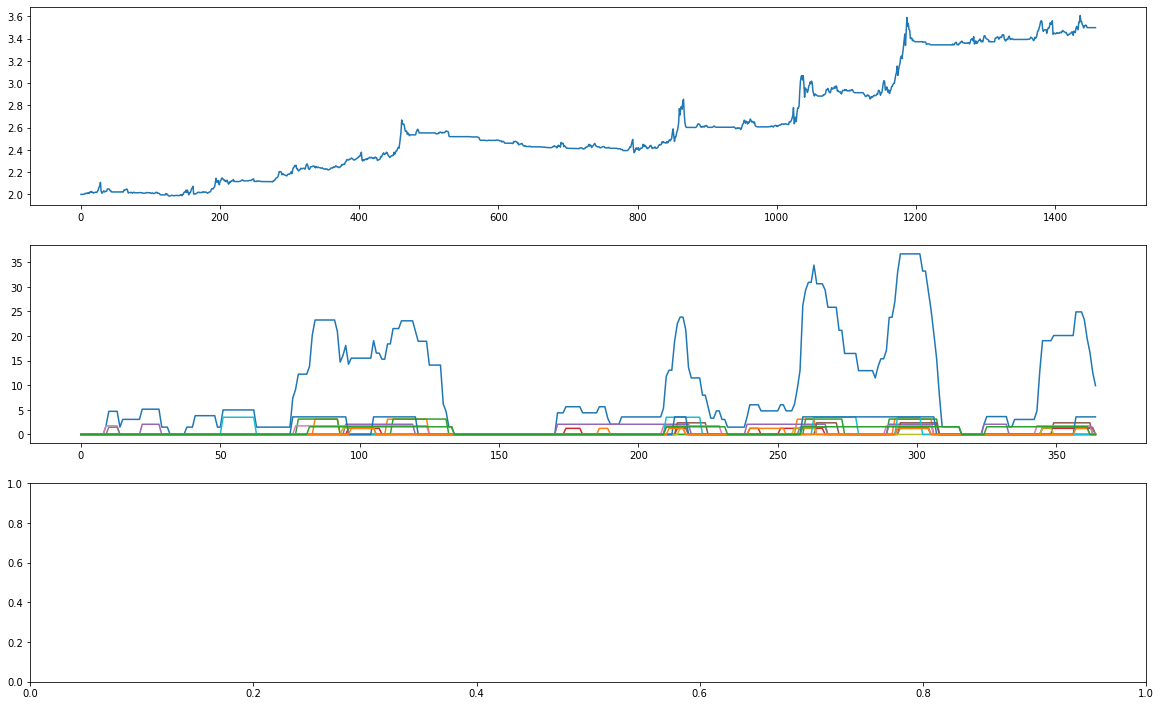

In [332]:
fig, ax = plt.subplots(3, figsize = [20,20/1.61])
ax[0].plot(np.array(fundsHist)/100)
ax[1].plot(sum([np.array(scoreHist[i]) for i in range(len(scoreHist))]))
[ax[1].plot(scoreHist[i], label = goodAssets[i]) for i in range(len(scoreHist))]
ax[1].legend()
#ax[1].plot(scoreHist[1])
ff.makeMarketPerformancePlot(goodAllCloseData86400, ax[2])

## Backtest Multi-Asset Strategy B

### 60

In [3]:
periods = 365*4
granularity = 60*60*6
backtestDateEnd = datetime.datetime.now()
backtestDateStart = backtestDateEnd - datetime.timedelta(seconds = periods*granularity)
#backtestDateEnd = datetime.datetime.now()
nOfDays = int((backtestDateEnd - backtestDateStart).total_seconds()/datetime.timedelta(seconds = granularity).total_seconds())
fail = True
while fail:
    try:
        allData60 = [cf.getData(Client, asset, backtestDateStart, backtestDateEnd, granularity, verbose = False, interpolate = True) for asset in assets]
        fail = False
    except:
        pass
clear_output()

In [4]:
tradeFee = 0.005
goodAllData60 = []
goodAssets = []
goodAllCloseData60 = []
for i in range(len(assets)):
    if len(allData60[i][backtestDateStart:backtestDateEnd]) == nOfDays:
        goodAllData60 += [allData60[i][backtestDateStart:backtestDateEnd]]
        goodAllCloseData60 += [allData60[i][backtestDateStart:backtestDateEnd]['close'].values]
        goodAssets += [assets[i]]

buyHistB = []
baseScores = [0 for _ in range(len(goodAssets))]
for i in range(len(goodAssets)):
    with open(cf.dbPath + "/" + goodAssets[i] + "/Str" + 'B' + "Params_" + str(granularity) + ".pkl", 'rb') as f:
        best = pkl.load(f)
        parameters = best['parameters']
        score = best['score']
        baseScores[i] += score
    nLims = np.array([2,max([len(data) for data in goodAllCloseData60])])
    buyHistB += [ff.backtestStrategyB(goodAllCloseData60[i], parameters[0], parameters[1], parameters[2], nLims)[2]]
     
buyHistC = []
for i in range(len(goodAssets)):
    with open(cf.dbPath + "/" + goodAssets[i] + "/Str" + 'C' + "Params_" + str(granularity) + ".pkl", 'rb') as f:
        best = pkl.load(f)
        parameters = best['parameters']
        score = best['score']
        baseScores[i] += score
    nLims = np.array([2,max([len(data) for data in goodAllCloseData60])])
    buyHistC += [ff.backtestStrategyC(goodAllCloseData60[i], parameters[0], parameters[1], parameters[2], parameters[3], parameters[4], nLims)[2]]
    
baseScores = np.array(baseScores)
baseScores = baseScores/sum(baseScores)

buyHist = [[0 for j in range(len(buyHistB[i]))] for i in range(len(buyHistB))]
for i in range(len(buyHistB)):
    for j in range(len(buyHistB[i])):
        buyHist[i][j] = buyHistB[i][j] and buyHistC[i][j]
        
assetsRanking_df = pd.DataFrame({'asset':goodAssets, 'score':baseScores, 'goodAllData60':goodAllData60, 'goodAllCloseData60':goodAllCloseData60, 'buyHist':buyHist})
assetsRanking_df.sort_values(by = 'score', ascending = False, inplace = True)
goodAssets = assetsRanking_df['asset'].values
baseScores = assetsRanking_df['score'].values
goodAllData60 = assetsRanking_df['goodAllData60'].values
goodAllCloseData60 = assetsRanking_df['goodAllCloseData60'].values
buyHist = assetsRanking_df['buyHist'].values

fundsHist = []
realBuyHist = [[False for j in range(len(buyHist[i]))] for i in range(len(buyHist))]
buyState = [False for _ in range(len(goodAssets))]
buyPrice = [0 for _ in range(len(goodAssets))]
buyAmount = [0 for _ in range(len(goodAssets))]
funds = [0 for _ in range(len(goodAssets))] + [600]
nOfTrades = [0 for _ in range(len(goodAssets))]
monthlyDeposits = 0
deposits = [monthlyDeposits]
for i in range(1, len(buyHist[0])):
    if i % 120 == 0:
        funds[-1] += monthlyDeposits
        deposits += [deposits[-1] + monthlyDeposits]
    else:
        deposits += [deposits[-1]]
    totalFunds = sum(funds)
    negotiableFunds = totalFunds*.9
    currentPrices = [goodAllCloseData60[j][i] for j in range(len(goodAssets))]
    
    buyLimit = 4
    
    buyFull = sum(buyState) >= buyLimit
    #buyFull = False
    for j in range(len(goodAssets)):
        buyFull = sum(buyState) >= buyLimit
        if not buyHist[j][i-1] and buyHist[j][i] and not buyState[j] and not buyFull:
        #if buyHist[j][i] and not buyState[j] and not buyFull:
        
            realBuyHist[j][i] = True
            buyState[j] = True
            buyPrice[j] = currentPrices[j]
            #buyAmount[j] = baseScores[j]*negotiableFunds/currentPrices[j]*(1-tradeFee)
            buyAmount[j] = 1/buyLimit*negotiableFunds/currentPrices[j]*(1-tradeFee)
            funds[-1] -= buyAmount[j]*currentPrices[j]
            funds[j] = buyAmount[j]*currentPrices[j]
            nOfTrades[j] += 1

        elif not buyHist[j][i] and buyState[j]:
            realBuyHist[j][i] = False
            buyState[j] = False
            funds[-1] += buyAmount[j]*currentPrices[j]*(1-tradeFee)
            funds[j] = 0
            buyAmount[j] = 0
        else:
            realBuyHist[j][i] = realBuyHist[j][i-1]
            funds[j] = buyAmount[j]*currentPrices[j]
        
            
    totalFunds = sum(funds)

    fundsHist += [totalFunds]

returnsHist = np.array(ff.returns(np.array(fundsHist)))
intReturns = (np.prod(1 + returnsHist[1:]))**((31536000/granularity)/periods)-1
intVol = np.std(returnsHist[1:])*np.sqrt(granularity*periods/31536000)
SR = intReturns/intVol
print("Annualized Returns: " + str(intReturns))
print("Return Volatility: " + str(intVol))
print("SharpeRatio: " + str(SR))


Annualized Returns: 8.621205429335875
Return Volatility: 0.01829033692204846
SharpeRatio: 471.3530136748475


Ordering by best score, Edge buying with AND Strategy and buyLimit of 4

Annualized Returns: 9.885984557108518
Return Volatility: 0.018765637515585097
SharpeRatio: 526.8131471098749

Edge buying with AND Strategy and buyLimit of 5

Annualized Returns: 9.133776550214922
Return Volatility: 0.017673108325778585
SharpeRatio: 516.8177765816152

Not edge buying

Annualized Returns: 9.294765543389158
Return Volatility: 0.028431893291587264
SharpeRatio: 326.91335213119254

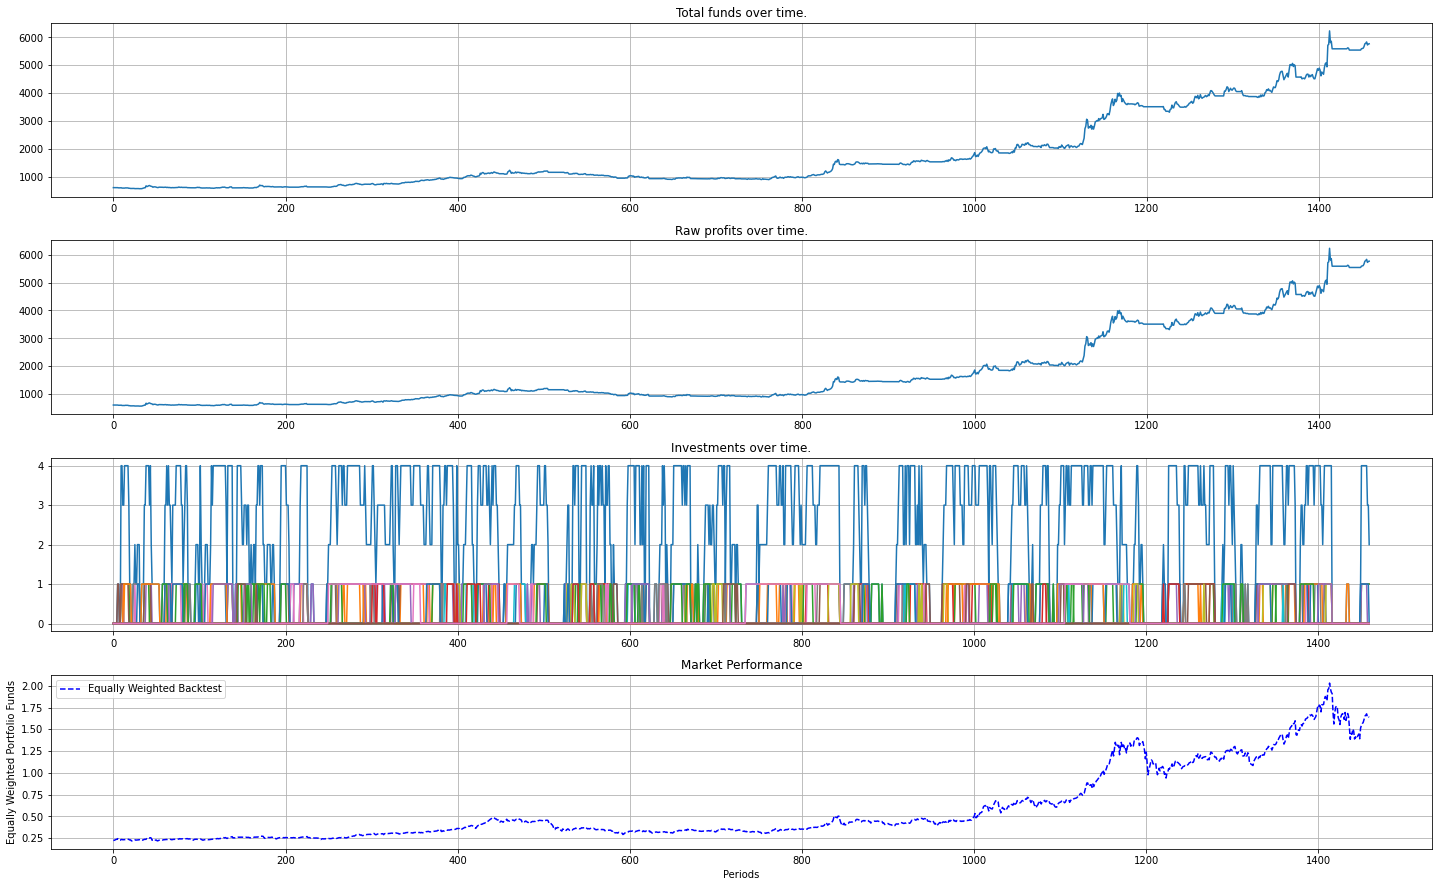

In [5]:
fundsHist0 = fundsHist.copy()
fig, ax = plt.subplots(4, figsize = [20,20/1.61])
ax[0].plot(np.array(fundsHist0))
ax[0].set_title("Total funds over time.")
ax[0].grid()

ax[1].plot(np.array(fundsHist0) - deposits[1:], label = '0')
ax[1].set_title("Raw profits over time.")
ax[1].grid()

ax[2].plot(sum([np.array(realBuyHist[i]) for i in range(len(buyHist))]))
[ax[2].plot(realBuyHist[i], label = goodAssets[i]) for i in range(len(buyHist))]
ax[2].set_title("Investments over time.")
ax[2].grid()
#ax[1].legend()
ff.makeMarketPerformancePlot(goodAllCloseData60, ax[3])
fig.tight_layout()

In [287]:
for i in range(len(goodAssets)):
    print(goodAssets[i] + ": " + str(realBuyHist[i][-2]))

ETH-USD: True
BTC-USD: True
LTC-USD: False
LINK-USD: False
BCH-USD: False
ETC-USD: False
XLM-USD: False
DASH-USD: False
ATOM-USD: False
ALGO-USD: True
KNC-USD: False
XTZ-USD: False
EOS-USD: False
OXT-USD: False
REP-USD: False


In [8]:
datetime.datetime.now().minute

40

In [167]:
with open("/home/andrerg01/AutoTraders/fredinhouTradingBot/Coinbase_Trader_4.0/logs/checkpointSMS.pkl",'rb') as f:
    print(pkl.load(f))

615.4203226132954


,low,high,open,close,volume
date,,,,,
2020-04-28 00:00:00,192.50,196.99,196.88,194.99,33224.988000
2020-04-28 06:00:00,194.10,197.37,194.96,196.27,19584.280266
2020-04-28 12:00:00,194.30,197.95,196.27,196.06,29684.430254
2020-04-28 18:00:00,195.33,197.86,196.06,196.67,23114.719758
2020-04-29 00:00:00,196.64,200.00,196.64,199.76,44382.240422
...,...,...,...,...,...
2021-04-26 18:00:00,2429.91,2542.04,2512.42,2534.00,79251.231134
2021-04-27 00:00:00,2484.56,2550.00,2533.99,2530.53,39141.321238
2021-04-27 06:00:00,2530.53,2581.68,2531.05,2576.59,37841.085888


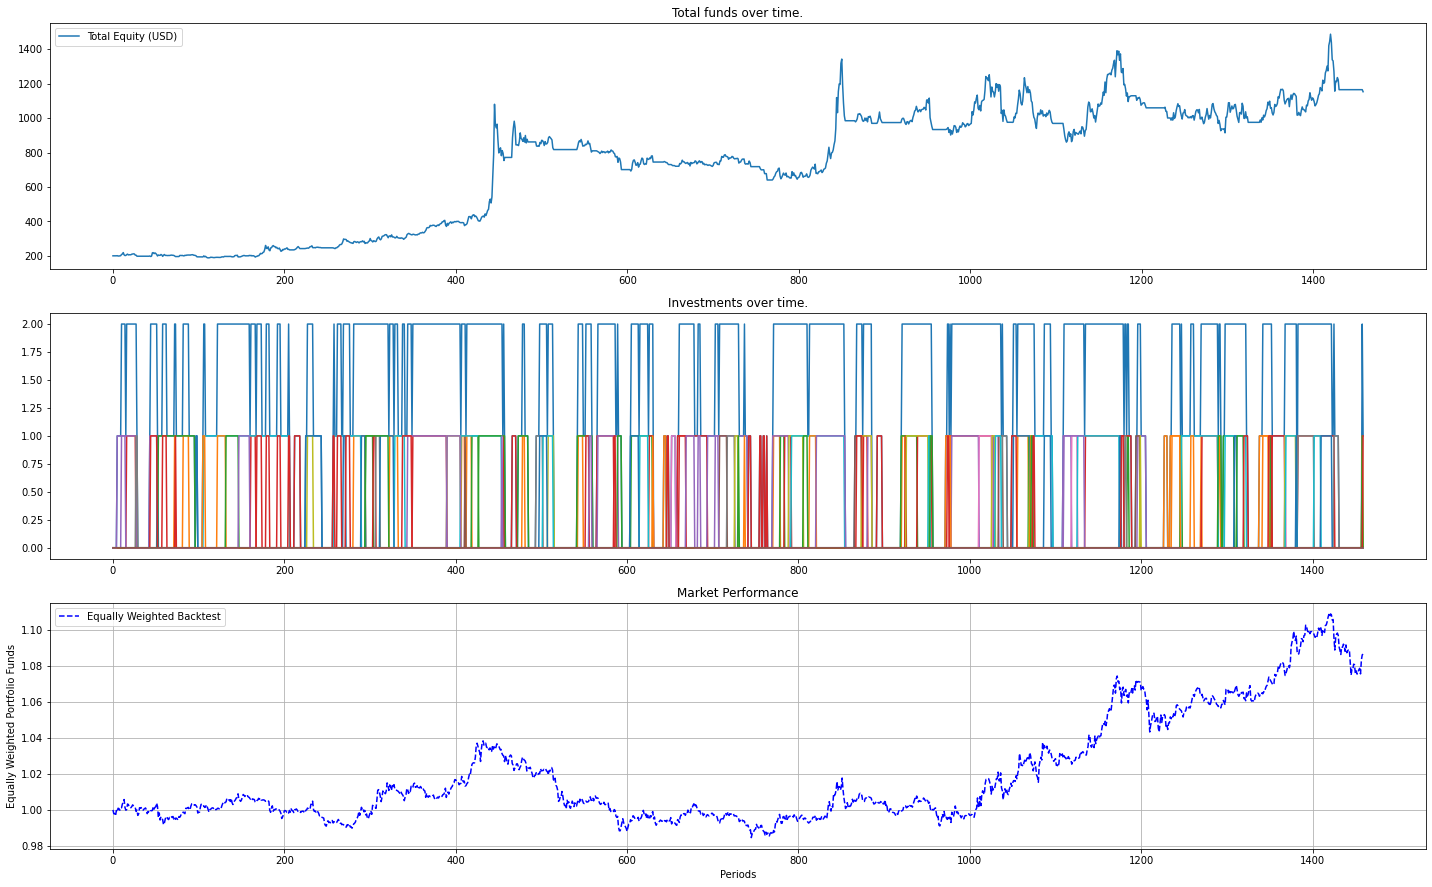

In [187]:
fundsHist0 = fundsHist.copy()
fig, ax = plt.subplots(3, figsize = [20,20/1.61])
ax[0].plot(np.array(fundsHist0), label = 'Total Equity (USD)')
# ax[0].plot(np.array(fundsHist1), label = '1')
# ax[0].plot(np.array(fundsHist2), label = '2')
# ax[0].plot(np.array(fundsHist3), label = '3')
# ax[0].plot(np.array(fundsHist4), label = '4')
# ax[0].plot(np.array(fundsHist5), label = '5')
# ax[0].plot(np.array(fundsHist6), label = '6')
# ax[0].plot(np.array(fundsHist7), label = '7')
# ax[0].plot(np.array(fundsHist8), label = '8')

ax[0].legend()

ax[0].set_title("Total funds over time.")

ax[1].plot(sum([np.array(realBuyHist[i]) for i in range(len(buyHist))]))
[ax[1].plot(realBuyHist[i], label = goodAssets[i]) for i in range(len(buyHist))]
ax[1].set_title("Investments over time.")
#ax[1].legend()
ff.makeMarketPerformancePlot(goodAllCloseData60, ax[2])
fig.tight_layout()

granularity

In [247]:
goodAllCloseData60

[array([0.212 , 0.2217, 0.2161, ..., 1.2822, 1.2706, 1.3044]),
 array([ 2.737,  2.834,  2.801, ..., 23.11 , 22.46 , 23.36 ]),
 array([239.6 , 241.1 , 240.26, ..., 879.77, 876.07, 882.05]),
 array([ 7706.59,  7742.32,  7741.03, ..., 55237.57, 54959.55, 55115.59]),
 array([ 81.45 ,  82.401,  81.999, ..., 290.207, 284.138, 289.099]),
 array([2.715, 2.743, 2.73 , ..., 6.09 , 5.951, 6.047]),
 array([ 6.063,  6.127,  6.076, ..., 33.694, 33.707, 33.578]),
 array([ 194.99,  196.27,  196.06, ..., 2576.59, 2648.42, 2627.94]),
 array([0.6587, 0.6702, 0.6627, ..., 2.958 , 3.2809, 3.2   ]),
 array([ 3.61383,  3.69787,  3.68326, ..., 36.95478, 37.0131 , 36.57592]),
 array([ 43.99,  44.57,  44.55, ..., 257.4 , 258.98, 259.32]),
 array([0.1774, 0.1812, 0.1766, ..., 0.6398, 0.625 , 0.6363]),
 array([10.34, 10.4 , 10.49, ..., 41.8 , 41.21, 41.28]),
 array([0.069613, 0.070193, 0.068603, ..., 0.518964, 0.506835, 0.507823]),
 array([2.715 , 2.8005, 2.7909, ..., 5.4505, 5.3488, 5.3827])]

In [222]:
a = ['REP-USD', 'OXT-USD', 'EOS-USD', 'XTZ-USD', 'KNC-USD', 'ALGO-USD', 'ATOM-USD', 'DASH-USD', 'XLM-USD', 'ETC-USD', 'BCH-USD', 'LINK-USD', 'LTC-USD', 'BTC-USD', 'ETH-USD']
a.reverse()
a

['ETH-USD',
 'BTC-USD',
 'LTC-USD',
 'LINK-USD',
 'BCH-USD',
 'ETC-USD',
 'XLM-USD',
 'DASH-USD',
 'ATOM-USD',
 'ALGO-USD',
 'KNC-USD',
 'XTZ-USD',
 'EOS-USD',
 'OXT-USD',
 'REP-USD']

In [724]:
63000/60

1050.0

In [3]:
a = pd.DataFrame({'a':[1,2,3],'b':[3,2,1]})
a

,a,b
0,1,3
1,2,2
2,3,1


In [56]:
a

,a,b
0,1,3
1,2,2
2,3,1


In [264]:
assets = ['ALGO-USD', 'ATOM-USD', 'BCH-USD', 'BTC-USD', 'DASH-USD', 'EOS-USD', 'ETC-USD', 'ETH-USD', 'KNC-USD', 'LINK-USD', 'LTC-USD', 'OXT-USD', 'REP-USD', 'XLM-USD', 'XTZ-USD']

def buy(Client, asset, size):
    complete = False
    fail = False
    while not complete and not fail:
        order = Client.place_market_order(product_id = asset, side = 'buy', size = size)
        if len(order) > 0 and isinstance(order, dict):
            if 'message' in order.keys():
                if order['message'].startswith('size is too accurate.'):
                    precision = -int(np.log10(eval(order['message'].split(" ")[-1])))
                    size = round(size, precision)
                elif order['message'].startswith('size is too small'):
                    fail = True
                if order['message'].startswith('Insufficient'):
                    fail = True
            elif 'id' in order.keys():
                complete = True
        else:
            fail = True
    return order

def sell(Client, asset, size):
    complete = False
    fail = False
    pct = 100
    while not complete and not fail:
        order = Client.place_market_order(product_id = asset, side = 'sell', size = size*pct/100)
        if len(order) > 0 and isinstance(order, dict):
            if 'message' in order.keys():
                if order['message'].startswith('size is too accurate.'):
                    precision = -int(np.log10(eval(order['message'].split(" ")[-1])))
                    size = round(size, precision)
                if order['message'].startswith('Insufficient'):
                    pct -= 1
            elif 'id' in order.keys():
                complete = True
        else:
            fail = True
    return order

In [271]:
Client.place_market_order(product_id = assets[0], side = 'buy', size = 5/currentPrices[0])

{'message': 'size is too small. Minimum size is 0.00010000'}

In [428]:

goodAssets

['BTC-USD', 'EOS-USD', 'ETC-USD', 'ETH-USD', 'LTC-USD', 'REP-USD', 'XLM-USD']

In [ ]:
len({'id': 'dac1e0df-0565-402d-b335-36da441b4a9b', 'size': '7', 'product_id': 'ALGO-USD', 'side': 'buy', 'stp': 'dc', 'funds': '211.4692', 'type': 'market', 'post_only': False, 'created_at': '2021-04-22T01:36:51.605735Z', 'fill_fees': '0', 'filled_size': '0', 'executed_value': '0', 'status': 'pending', 'settled': False})

In [235]:
order = Client.place_market_order(product_id = 'ALGO-USD', side = 'sell', size = 100000)
order

{'message': 'Insufficient funds'}

In [229]:
order

{'message': 'size must be a number'}

In [3]:
tempAssets = ['BTC-USD',
 'DASH-USD',
 'EOS-USD',
 'ETC-USD',
 'ETH-USD',
 'KNC-USD',
 'LINK-USD',
 'LTC-USD',
 'OXT-USD',
 'REP-USD',
 'XLM-USD',
 'XTZ-USD']

In [262]:
currentPrices = currentPrices[3:]

In [276]:
baseScores*200

array([14.4731087 , 15.69884207, 10.3131879 , 16.64667822, 11.63586875,
       13.70918665, 12.81418643, 14.29846098, 18.95338068, 17.37420721,
       11.17755714,  8.9540081 ,  8.79363951, 11.94612189, 13.21156577])

In [ ]:
['BTC-USD',
 'DASH-USD',
 'EOS-USD',
 'ETC-USD',
 'ETH-USD',
 'KNC-USD',
 'LINK-USD',
 'LTC-USD',
 'OXT-USD',
 'REP-USD',
 'XLM-USD',
 'XTZ-USD']

# Cross Correlation

Data1 Length: 300
Data2 Length: 300
Data1 peak correlation index: 298
Cross correlation peak index: 298 -- Intensity: 0.865788654166784


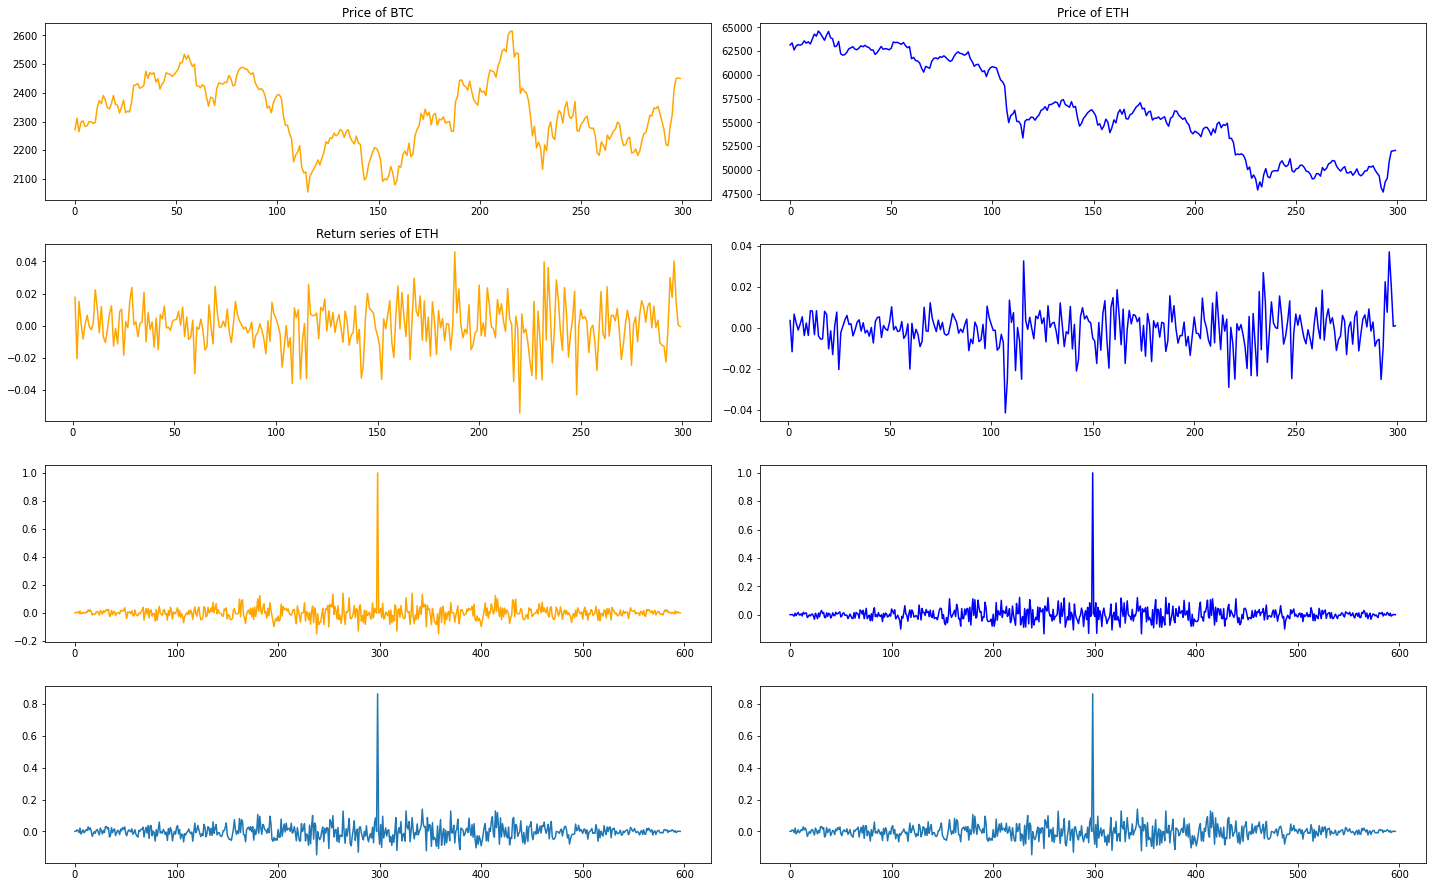

In [57]:
periods = 300
granularity = 60*60
end = datetime.datetime.now()
start = end - datetime.timedelta(seconds = periods*granularity)
#backtestDateEnd = datetime.datetime.now()
nOfDays = int((end - start).total_seconds()/datetime.timedelta(seconds = granularity).total_seconds())
fail = True
while fail:
    try:
        dataBTC = cf.getData(Client, 'ETH-USD', start, end, granularity, verbose = False, interpolate = True)
        dataETH = cf.getData(Client, 'BTC-USD', start, end, granularity, verbose = False, interpolate = True)
        fail = False
    except:
        print("Fail")
        pass

clear_output()

print("Data1 Length: " + str(len(dataBTC)))
print("Data2 Length: " + str(len(dataETH)))

closeSeriesBTC = dataBTC['close'].values
closeSeriesETH = dataETH['close'].values

returnSeriesBTC = ff.returns(closeSeriesBTC)
returnSeriesETH = ff.returns(closeSeriesETH)

autoCorrBTC = np.correlate(returnSeriesBTC[1:], returnSeriesBTC[1:], mode = 'full')
autoCorrETH = np.correlate(returnSeriesETH[1:], returnSeriesETH[1:], mode = 'full')

normReturnSeriesBTC = returnSeriesBTC/np.sqrt(np.max(autoCorrBTC))
normReturnSeriesETH = returnSeriesETH/np.sqrt(np.max(autoCorrETH))

autoCorrBTC = autoCorrBTC/(np.max(autoCorrBTC))
autoCorrETH = autoCorrETH/(np.max(autoCorrETH))

corrBTC_ETH = np.correlate(normReturnSeriesBTC[1:], normReturnSeriesETH[1:], mode = 'full')
corrETH_BTC = np.correlate(normReturnSeriesETH[1:], normReturnSeriesBTC[1:], mode = 'full')

fig, ax = plt.subplots(4, 2, figsize = [20,20/1.61])
ax[0, 0].plot(closeSeriesBTC, color = 'orange', label = 'BTC')
ax[0, 0].set_title("Price of BTC")
ax[0, 1].plot(closeSeriesETH, color = 'blue', label = 'ETH')
ax[0, 1].set_title("Price of ETH")

ax[1, 0].plot(returnSeriesBTC, color = 'orange')
ax[1, 0].set_title("Return series of BTC")
ax[1, 1].plot(returnSeriesETH, color = 'blue')
ax[1, 0].set_title("Return series of ETH")


ax[2, 0].plot(autoCorrBTC, color = 'orange')
ax[2, 1].plot(autoCorrETH, color = 'blue')

ax[3, 0].plot(corrBTC_ETH)
ax[3, 1].plot(corrBTC_ETH)

fig.tight_layout()

print("Data1 peak correlation index: " + str(np.argmax(autoCorrBTC)))
print("Cross correlation peak index: " + str(np.argmax(corrBTC_ETH)) + " -- Intensity: " + str(np.max(corrBTC_ETH)))

In [104]:
diffs = {}
intensities = {}
fail = True
periods = 10
granularity = 60
end = datetime.datetime.now()
start = end - datetime.timedelta(seconds = periods*granularity)
#backtestDateEnd = datetime.datetime.now()
fail = True
while fail:
    try:
        allData = [cf.getData(Client, asset, start, end, granularity, verbose = False, interpolate = True) for asset in assets]
        fail = False
    except:
        print("Fail")
        pass
clear_output()
for i in range(len(assets)):
    diffs[assets[i]] = {assets[j]:np.nan for j in range(i)}
    diffs[assets[i]][assets[i]] = 0
    intensities[assets[i]] = {assets[j]:np.nan for j in range(i)}
    intensities[assets[i]][assets[i]] = 1.0000000000
    for j in range(i+1, len(assets)):
        clear_output()
        print(assets[i] + " - " + assets[j])
        
        dataBTC = allData[i]
        dataETH = allData[j]

        print("Data1 Length: " + str(len(dataBTC)))
        print("Data2 Length: " + str(len(dataETH)))
        if len(dataBTC) == len(dataETH):
            closeSeriesBTC = dataBTC['close'].values
            closeSeriesETH = dataETH['close'].values

            returnSeriesBTC = ff.returns(closeSeriesBTC)
            returnSeriesETH = ff.returns(closeSeriesETH)

            autoCorrBTC = np.correlate(returnSeriesBTC[1:], returnSeriesBTC[1:], mode = 'full')
            autoCorrETH = np.correlate(returnSeriesETH[1:], returnSeriesETH[1:], mode = 'full')

            normReturnSeriesBTC = returnSeriesBTC/np.sqrt(np.max(autoCorrBTC))
            normReturnSeriesETH = returnSeriesETH/np.sqrt(np.max(autoCorrETH))

            autoCorrBTC = autoCorrBTC/(np.max(autoCorrBTC))
            autoCorrETH = autoCorrETH/(np.max(autoCorrETH))

            corrBTC_ETH = np.correlate(normReturnSeriesBTC[1:], normReturnSeriesETH[1:], mode = 'full')
            corrETH_BTC = np.correlate(normReturnSeriesETH[1:], normReturnSeriesBTC[1:], mode = 'full')

            diffs[assets[i]][assets[j]] = np.argmax(autoCorrBTC) - np.argmax(corrBTC_ETH)
            intensities[assets[i]][assets[j]] = np.max(corrBTC_ETH) - np.mean(corrBTC_ETH[find_peaks(corrBTC_ETH)[0]])
        else:
            diffs[assets[i]][assets[j]] = np.nan
            intensities[assets[i]][assets[j]] = np.nan

diffs = pd.DataFrame(diffs)
intensities = pd.DataFrame(intensities)
clear_output()
print("Done!")

Done!


In [107]:
treshold = 0.5
diffs_np = diffs[diffs != 0][abs(diffs) <= 2][intensities > treshold].to_numpy()
pairs = []
pairedAssets = []
for i in range(len(diffs_np)):
    for j in range(len(diffs_np)):
        if not np.isnan(diffs_np[i, j]):
            if assets[i] not in pairedAssets:
                pairedAssets += [assets[i]]
            if assets[j] not in pairedAssets:
                pairedAssets += [assets[j]]
            print("Good pair: " + assets[i] + " (" + str(i) + ") / " + assets[j] + " (" + str(j) + ")" + "   ---   Intensity: " + str(intensities.iloc[i, j]) + " / Lag: " + str(diffs_np[i, j]) + " periods.")
            pairs += [{"Asset1":assets[i], "Asset2":assets[j], "Intensity":intensities.iloc[i, j], "Lag":diffs_np[i, j]}]
            

Good pair: BTC-USD (8) / ALGO-USD (2)   ---   Intensity: 0.5052763653718852 / Lag: -1.0 periods.
Good pair: BTC-USD (8) / BAND-USD (5)   ---   Intensity: 0.5343626960408772 / Lag: -1.0 periods.
Good pair: GRT-USD (16) / BAND-USD (5)   ---   Intensity: 0.5615666175644061 / Lag: -1.0 periods.
Good pair: LINK-USD (18) / CGLD-USD (9)   ---   Intensity: 0.5072801416550191 / Lag: 1.0 periods.
Good pair: LTC-USD (20) / AAVE-USD (0)   ---   Intensity: 0.5884116048343293 / Lag: -1.0 periods.
Good pair: MATIC-USD (21) / BAND-USD (5)   ---   Intensity: 0.501036180130793 / Lag: -1.0 periods.
Good pair: OMG-USD (25) / ALGO-USD (2)   ---   Intensity: 0.6124757320191745 / Lag: -1.0 periods.
Good pair: SUSHI-USD (31) / BTC-USD (8)   ---   Intensity: 0.5300879888916897 / Lag: 1.0 periods.
Good pair: SUSHI-USD (31) / COMP-USD (10)   ---   Intensity: 0.518757150978987 / Lag: 1.0 periods.
Good pair: SUSHI-USD (31) / GRT-USD (16)   ---   Intensity: 0.5467778672290627 / Lag: 1.0 periods.
Good pair: SUSHI-US

In [108]:
assetPerformance = {}
for asset in pairedAssets:
    count = 0
    sumInt = 0
    sumLag = 0
    correlatedAssets = []
    for pair in pairs:
        if asset == pair['Asset1'] or asset == pair['Asset2']:
            count += 1
            sumInt += pair['Intensity']
            #Addition if coming first, subtraction of coming second
            if asset == pair['Asset1']:
                sumLag += pair['Lag']
                correlatedAssets += [pair['Asset2']]
            else:
                sumLag -= pair['Lag']
                correlatedAssets += [pair['Asset1']]
    assetPerformance[asset] = {"Lag Occourances":count, "Mean Intensity":sumInt/count, "Mean Lag":sumLag/count, "Correlated Assets": correlatedAssets}
        
assetPerformance = pd.DataFrame(assetPerformance).T.sort_values(by = "Lag Occourances")
assetPerformance

,Lag Occourances,Mean Intensity,Mean Lag,Correlated Assets
LINK-USD,1,0.50728,1.0,[CGLD-USD]
CGLD-USD,1,0.50728,-1.0,[LINK-USD]
LTC-USD,1,0.588412,-1.0,[AAVE-USD]
XTZ-USD,1,0.549366,1.0,[MATIC-USD]
ETC-USD,1,0.500381,-1.0,[YFI-USD]
ZEC-USD,1,0.681402,-1.0,[AAVE-USD]
ALGO-USD,2,0.558876,1.0,"[BTC-USD, OMG-USD]"
GRT-USD,2,0.554172,-1.0,"[BAND-USD, SUSHI-USD]"
AAVE-USD,2,0.634907,1.0,"[LTC-USD, ZEC-USD]"
MATIC-USD,2,0.525201,-1.0,"[BAND-USD, XTZ-USD]"


Data1 Length: 10
Data2 Length: 10
Data1 peak correlation index: 8
Cross correlation peak index: 9 -- Intensity: 0.7535819424039945


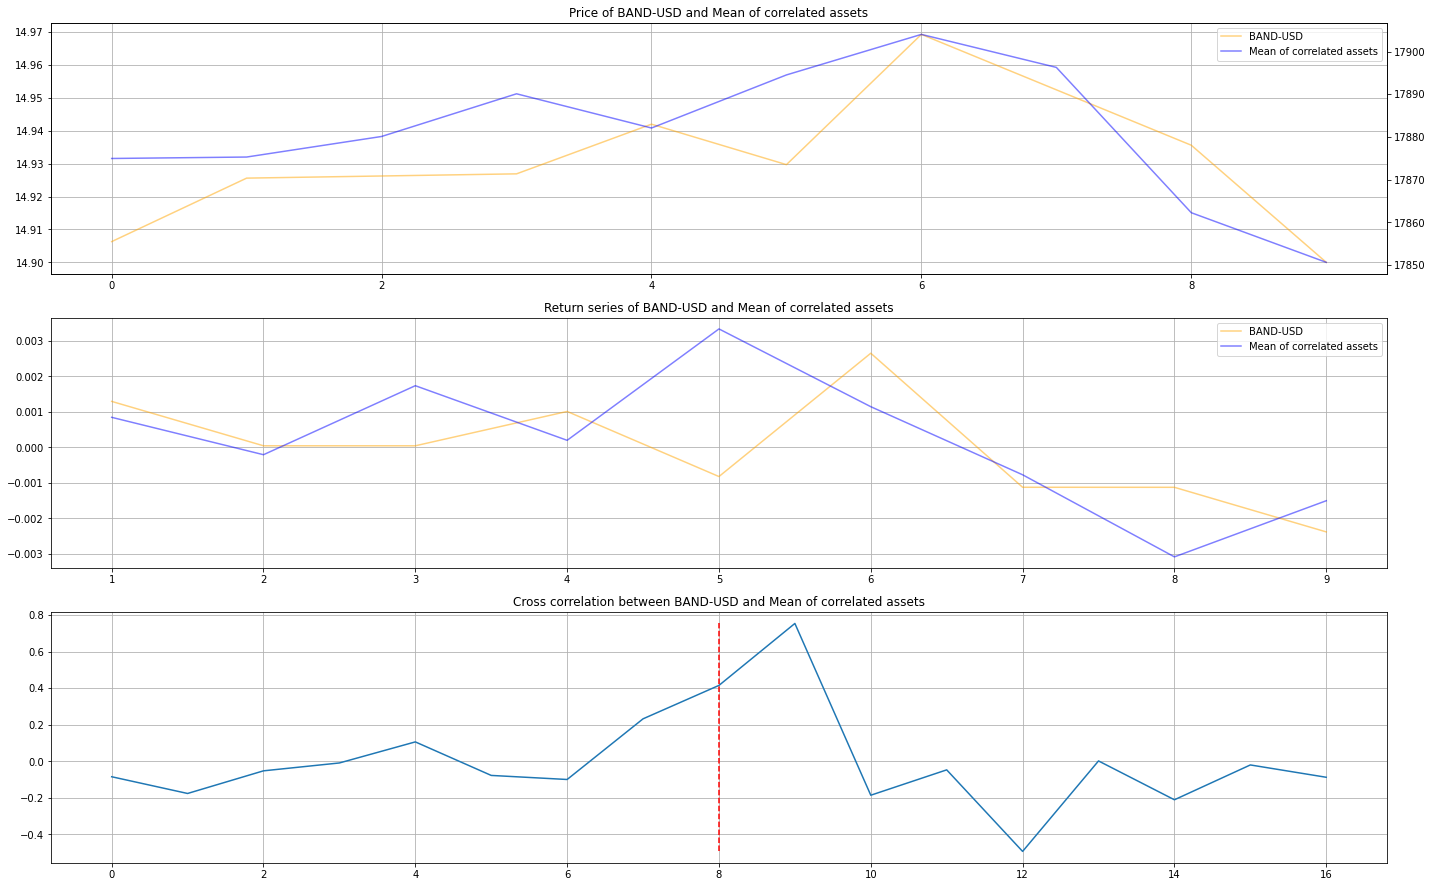

In [110]:
i = assets.index(assetPerformance.iloc[-2].name)
correlatedAssetsidx = [assets.index(asset) for asset in assetPerformance.iloc[-2]['Correlated Assets']]
dataBTC = allData[i]
dataETH = allData[1]

clear_output()

print("Data1 Length: " + str(len(dataBTC)))
print("Data2 Length: " + str(len(dataETH)))

closeSeriesBTC = dataBTC['close'].values
closeSeriesETH = sum([np.array(allData[i]['close'].values/len(correlatedAssetsidx)) for i in correlatedAssetsidx])

returnSeriesBTC = ff.returns(closeSeriesBTC)
#returnSeriesETH = ff.returns(closeSeriesETH)
returnSeriesETH = sum([np.array(ff.returns(allData[i]['close'].values)/len(correlatedAssetsidx)) for i in correlatedAssetsidx])

autoCorrBTC = np.correlate(returnSeriesBTC[1:], returnSeriesBTC[1:], mode = 'full')
autoCorrETH = np.correlate(returnSeriesETH[1:], returnSeriesETH[1:], mode = 'full')

normReturnSeriesBTC = returnSeriesBTC/np.sqrt(np.max(autoCorrBTC))
normReturnSeriesETH = returnSeriesETH/np.sqrt(np.max(autoCorrETH))

autoCorrBTC = autoCorrBTC/(np.max(autoCorrBTC))
autoCorrETH = autoCorrETH/(np.max(autoCorrETH))

corrBTC_ETH = np.correlate(normReturnSeriesBTC[1:], normReturnSeriesETH[1:], mode = 'full')
corrETH_BTC = np.correlate(normReturnSeriesETH[1:], normReturnSeriesBTC[1:], mode = 'full')

fig, ax = plt.subplots(3, figsize = [20,20/1.61])

ax[0].plot(closeSeriesBTC, color = 'orange', label = assets[i], alpha = 0.5)
ax[0].set_title("Price of " + assets[i] + " and " + "Mean of correlated assets")
ax0_2 = ax[0].twinx()
ax0_2.plot(closeSeriesETH, color = 'blue', label = "Mean of correlated assets", alpha = 0.5)

lines, labels = ax[0].get_legend_handles_labels()
lines2, labels2 = ax0_2.get_legend_handles_labels()
ax0_2.legend(lines + lines2, labels + labels2, loc=0)
ax[0].grid(which='both')


ax[1].plot(returnSeriesBTC, color = 'orange', label = assets[i], alpha = 0.5)
ax[1].set_title("Return series of " + assets[i] + " and " + "Mean of correlated assets")
ax[1].plot(returnSeriesETH, color = 'blue', label = "Mean of correlated assets", alpha = 0.5)
ax[1].legend()
ax[1].grid(which='both')

ax[2].plot(corrBTC_ETH)
ax[2].set_title("Cross correlation between " + assets[i] + " and " + "Mean of correlated assets")
ax[2].plot([np.argmax(autoCorrBTC), np.argmax(autoCorrBTC)],[np.min(corrBTC_ETH), np.max(corrBTC_ETH)], '--r')
ax[2].grid(which='both')

fig.tight_layout()

print("Data1 peak correlation index: " + str(np.argmax(autoCorrBTC)))
print("Cross correlation peak index: " + str(np.argmax(corrBTC_ETH)) + " -- Intensity: " + str(np.max(corrBTC_ETH)))

In [38]:
corrBTC_ETH

array([ 0.00451888, -0.00172526, -0.01659131, -0.16526034, -0.26511445,
       -0.43670104, -0.00745831,  0.2380065 ,  0.70177958,  0.78903342,
        0.2205728 , -0.00815872, -0.38865306, -0.13230946, -0.02614395,
       -0.04516341, -0.03875635])

In [44]:

peaks, _ = find_peaks(corrBTC_ETH)
results_half = peak_widths(corrBTC_ETH, [9], rel_height=0.5)

In [103]:
v

0.17426800873377696

In [52]:
np.argmax(autoCorrBTC)



1.1473521360035193

In [283]:
import yfinance as yf
start="2018-04-26"
endTrain = "2020-04-26"
end="2021-04-26"

dataPBR = yf.download("PBR", start=start, end=end)
dataPBR = dataPBR.drop('Adj Close', axis = 'columns')
dataPBR.columns = ['open', 'high', 'low', 'close', 'volume']
dataPBR_T = yf.download("PBR", start=start, end=endTrain)
dataPBR_T = dataPBR_T.drop('Adj Close', axis = 'columns')
dataPBR_T.columns = ['open', 'high', 'low', 'close', 'volume']


dataBP = yf.download("BP", start=start, end=end)
dataBP = dataBP.drop('Adj Close', axis = 'columns')
dataBP.columns = ['open', 'high', 'low', 'close', 'volume']
dataBP_T = yf.download("BP", start=start, end=endTrain)
dataBP_T = dataBP_T.drop('Adj Close', axis = 'columns')
dataBP_T.columns = ['open', 'high', 'low', 'close', 'volume']


dataXOM = yf.download("XOM", start=start, end=end)
dataXOM = dataXOM.drop('Adj Close', axis = 'columns')
dataXOM.columns = ['open', 'high', 'low', 'close', 'volume']
dataXOM_T = yf.download("XOM", start=start, end=endTrain)
dataXOM_T = dataXOM_T.drop('Adj Close', axis = 'columns')
dataXOM_T.columns = ['open', 'high', 'low', 'close', 'volume']


allData = [dataBP, dataPBR, dataXOM]
allCloseData = [dataBP['close'].values, dataPBR['close'].values, dataXOM['close'].values]

goodAssets = ['BP', 'PBR', 'XOM']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [214]:
dataBP.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

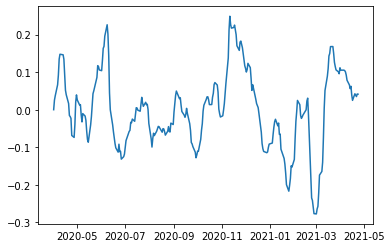

In [211]:
ff.backtest

In [312]:
tradeFee = 0

buyHistB = []
baseScores = [0 for _ in range(len(allData))]
for i in range(len(goodAssets)):
    nLims = np.array([2,max([len(data) for data in allCloseData])])
    if goodAssets[i] == 'PBR':
        buyHistB += [ff.backtestStrategyB(allCloseData[i], 11, 41, 53, nLims)[2]]
    elif goodAssets[i] == 'BP':
        buyHistB += [ff.backtestStrategyB(allCloseData[i], 12, 40, 72, nLims)[2]]
    elif goodAssets[i] == 'XOM':
        buyHistB += [ff.backtestStrategyB(allCloseData[i], 6, 44, 64, nLims)[2]]
    
buyHistC = []
for i in range(len(goodAssets)):
    nLims = np.array([2,max([len(data) for data in allCloseData])])
    if goodAssets[i] == 'PBR':
        buyHistC += [ff.backtestStrategyC(allCloseData[i], 1.90000000e+01, 2.10000000e+01, 7.00000000e+00, 1.22222222e-03,
        1.50000000e-03, nLims)[2]]
    elif goodAssets[i] == 'BP':
        buyHistC += [ff.backtestStrategyC(allCloseData[i], 2.20000000e+01, 3.70000000e+01, 7.00000000e+00, 9.44444444e-04,
        1.50000000e-03, nLims)[2]]
    elif goodAssets[i] == 'XOM':
        buyHistC += [ff.backtestStrategyC(allCloseData[i], 2.00000000e+01, 2.90000000e+01, 7.00000000e+00, 1.22222222e-03,
        1.50000000e-03, nLims)[2]]

baseScores = np.array(baseScores)
baseScores = baseScores/sum(baseScores)

buyHist = [[0 for j in range(len(buyHistB[i]))] for i in range(len(buyHistB))]
for i in range(len(buyHistB)):
    for j in range(len(buyHistB[i])):
        buyHist[i][j] = buyHistB[i][j] and buyHistC[i][j]


fundsHist = []
realBuyHist = [[False for j in range(len(buyHist[i]))] for i in range(len(buyHist))]
buyState = [False for _ in range(len(goodAssets))]
buyPrice = [0 for _ in range(len(goodAssets))]
buyAmount = [0 for _ in range(len(goodAssets))]
funds = [0 for _ in range(len(goodAssets))] + [1]
nOfTrades = [0 for _ in range(len(goodAssets))]
monthlyDeposits = 0
deposits = [monthlyDeposits]
for i in range(1, len(buyHist[0])):
    if i % 120 == 0:
        funds[-1] += monthlyDeposits
        deposits += [deposits[-1] + monthlyDeposits]
    else:
        deposits += [deposits[-1]]
    totalFunds = sum(funds)
    negotiableFunds = totalFunds*.9
    currentPrices = [allCloseData[j][i] for j in range(len(goodAssets))]
    
    buyLimit = 3
    
    #buyFull = sum(buyState) >= buyLimit
    buyFull = False
    for j in range(len(goodAssets)):
        #buyFull = sum(buyState) >= buyLimit
        if buyHist[j][i] and not buyState[j] and not buyFull:
            realBuyHist[j][i] = True
            buyState[j] = True
            buyPrice[j] = currentPrices[j]
            #buyAmount[j] = baseScores[j]*negotiableFunds/currentPrices[j]*(1-tradeFee)
            buyAmount[j] = 1/buyLimit*negotiableFunds/currentPrices[j]*(1-tradeFee)
            funds[-1] -= buyAmount[j]*currentPrices[j]
            funds[j] = buyAmount[j]*currentPrices[j]
            nOfTrades[j] += 1

        elif not buyHist[j][i] and buyState[j]:
            realBuyHist[j][i] = False
            buyState[j] = False
            funds[-1] += buyAmount[j]*currentPrices[j]*(1-tradeFee)
            funds[j] = 0
            buyAmount[j] = 0
        else:
            realBuyHist[j][i] = realBuyHist[j][i-1]
            funds[j] = buyAmount[j]*currentPrices[j]

        
            
    totalFunds = sum(funds)

    fundsHist += [totalFunds]

returnsHist = np.array(ff.returns(np.array(fundsHist)))
intReturns = (np.prod(1 + returnsHist[1:]))**(31536000/(60*60*24*365*3))-1
intVol = np.std(returnsHist[1:])*np.sqrt(31536000/(60*60*24))
SR = intReturns/intVol
print("Annualized Returns: " + str(intReturns))
print("Return Volatility: " + str(intVol))
print("SharpeRatio: " + str(SR))


Annualized Returns: 0.1640143829136942
Return Volatility: 0.15773751507868872
SharpeRatio: 1.0397931198033277


<ipython-input-312-e3093cac9e68>:28: RuntimeWarning: invalid value encountered in true_divide
  baseScores = baseScores/sum(baseScores)


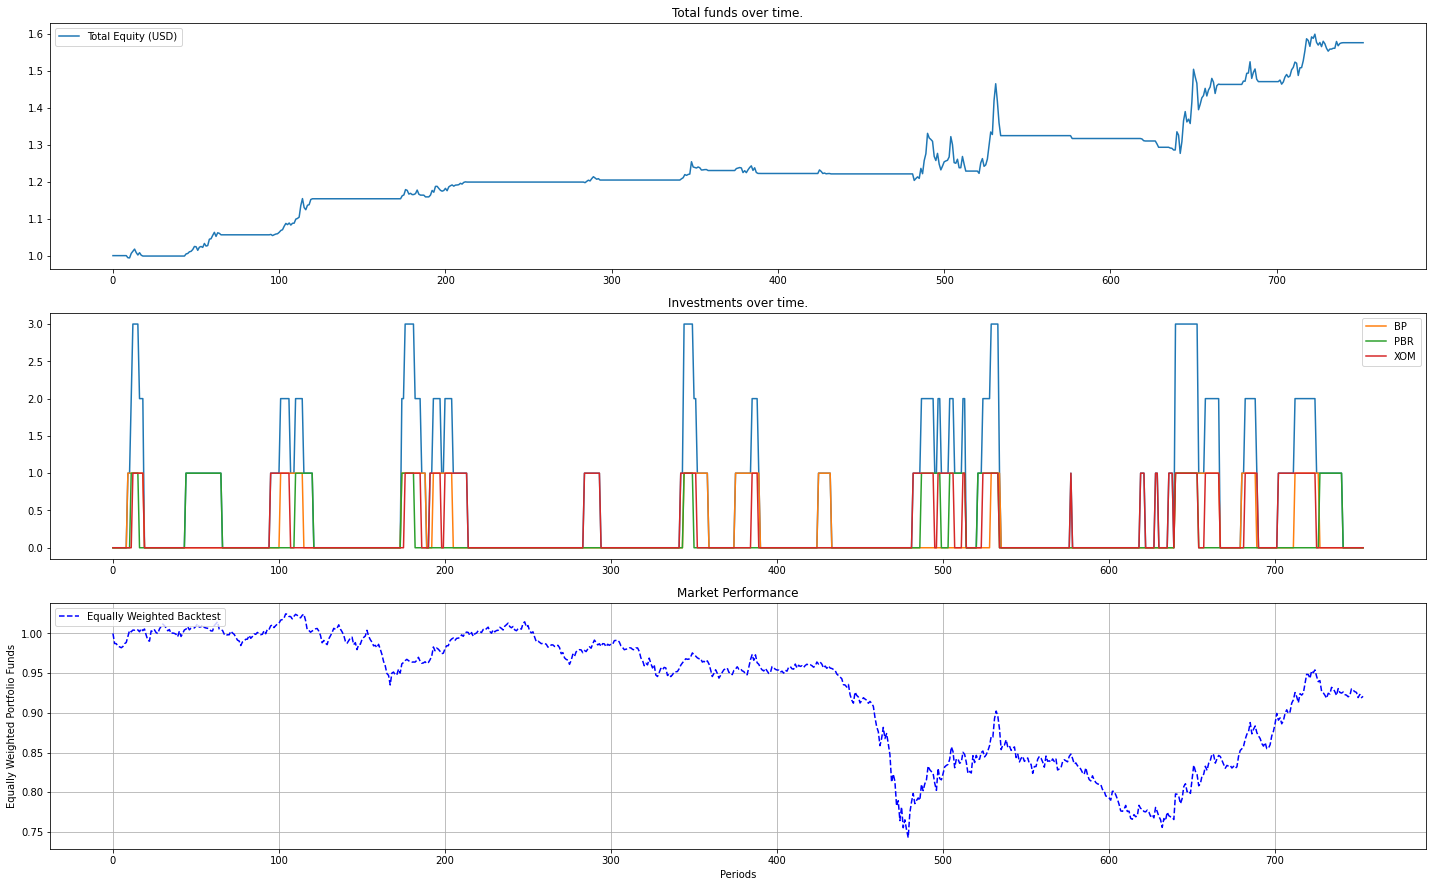

In [313]:
fundsHist0 = fundsHist.copy()
fig, ax = plt.subplots(3, figsize = [20,20/1.61])
ax[0].plot(np.array(fundsHist0), label = 'Total Equity (USD)')
# ax[0].plot(np.array(fundsHist1), label = '1')
# ax[0].plot(np.array(fundsHist2), label = '2')
# ax[0].plot(np.array(fundsHist3), label = '3')
# ax[0].plot(np.array(fundsHist4), label = '4')
# ax[0].plot(np.array(fundsHist5), label = '5')
# ax[0].plot(np.array(fundsHist6), label = '6')
# ax[0].plot(np.array(fundsHist7), label = '7')
# ax[0].plot(np.array(fundsHist8), label = '8')

ax[0].legend()

ax[0].set_title("Total funds over time.")

ax[1].plot(sum([np.array(realBuyHist[i]) for i in range(len(buyHist))]))
[ax[1].plot(realBuyHist[i], label = goodAssets[i]) for i in range(len(buyHist))]
ax[1].set_title("Investments over time.")
ax[1].legend()
ff.makeMarketPerformancePlot(allCloseData, ax[2])
fig.tight_layout()

In [282]:
realBuyHist[1][-30:]

[False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False]

In [289]:
#Optimizing Strategy B Parameters
RSIperiodVals = np.arange(5,int(0.1*len(dataPBR_T)))
RSILowVals = np.arange(20,49)
RSIHighVals = np.arange(51, 80)
#Minimum of one activation every 90 days
minN = int(len(dataXOM_T)/90)
#Maximum of one activation per 4 days
maxN = int(len(dataXOM_T)/4)
argCombinations = []
for p1 in RSIperiodVals:
    for p2 in RSILowVals:
        for p3 in RSIHighVals:
            argCombinations += [(dataXOM_T['close'].values, p1, p2, p3, np.array([minN, maxN], dtype = np.float64))]

with ThreadPoolExecutor(8) as ex:   
    results = ex.map(lambda p: ff.backtestStrategyB(*p), argCombinations)
results = np.array([result for result in results])
results_df = pd.DataFrame(results, columns = ['returns', 'lengths', 'purchasedBool', 'score', 'N', 'parameters'])
results_df = results_df.sort_values(by = 'score')
best = results_df.tail(10).sort_values(by = 'N').iloc[-1]
if best['score'] < 0:
    best['score'] = 0
best.to_dict()
best

<ipython-input-289-568818b6aee7>:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  results = np.array([result for result in results])


returns          [0.027916511812128324, 0.00012272559791986197,...
lengths          [12.0, 10.0, 12.0, 3.0, 26.0, 2.0, 1.0, 7.0, 5...
purchasedBool    [False, False, False, False, False, False, Fal...
score                                                     0.295351
N                                                               26
parameters                                             [6, 44, 64]
Name: 1550, dtype: object

In [290]:
#Optimizing Strategy CParameters
OSCperiod1Vals = np.arange(10,40)
OSCperiod2Vals = np.arange(20,50)
OSCperiod3Vals = np.arange(7,20)

OSCLowVals = np.linspace(-0.001, 0.0015, num = 10)
OSCHighVals = np.linspace(-0.001, 0.0015, num = 10)
#Minimum of one activation every 90 days
minN = int(len(dataXOM_T)/90)
#Maximum of one activation per 4 days
maxN = int(len(dataXOM_T)/4)
argCombinations = []
for p1 in OSCperiod1Vals:
    for p2 in OSCperiod2Vals:
        for p3 in OSCperiod3Vals:
            for p4 in OSCLowVals:
                for p5 in OSCHighVals:
                    if p2 > p1 > p3 and p5 > p4:
                        argCombinations += [(dataXOM_T['close'].values, p1, p2, p3, p4, p5, np.array([minN, maxN], dtype = np.float64))]
                        
with ThreadPoolExecutor(8) as ex:   
    results = ex.map(lambda p: ff.backtestStrategyC(*p), argCombinations)
results = np.array([result for result in results])
results_df = pd.DataFrame(results, columns = ['returns', 'lengths', 'purchasedBool', 'score', 'N', 'parameters'])
results_df = results_df.sort_values(by = 'score')
best = results_df.tail(10).sort_values(by = 'N').iloc[-1]
if best['score'] < 0:
    best['score'] = 0
best.to_dict()

<ipython-input-290-8ad98392d794>:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  results = np.array([result for result in results])


{'returns': array([ 0.00391054,  0.03511943,  0.11313161,  0.02517404,  0.02646934,
        -0.03762485,  0.12648119]),
 'lengths': array([ 7., 12., 38., 12., 12.,  4., 20.]),
 'purchasedBool': array([False, False, False, False, False, False, False, False, False,
        False, False, False,  True,  True,  True,  True,  True,  True,
         True, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False,  True,  True,  True,  True,
         True,  True,  Tru

In [316]:
data = yf.download("TKC", start=start, end=end)
data = data.drop('Adj Close', axis = 'columns')
data.columns = ['open', 'high', 'low', 'close', 'volume']

[*********************100%***********************]  1 of 1 completed


In [317]:
data

,open,high,low,close,volume
Date,,,,,
2018-04-26,8.71,8.85,8.70,8.83,231100
2018-04-27,8.82,8.90,8.80,8.85,148400
2018-04-30,8.87,8.89,8.59,8.65,428200
2018-05-01,8.59,8.61,8.50,8.50,212900
2018-05-02,8.21,8.35,8.16,8.27,549400
...,...,...,...,...,...
2021-04-19,4.68,4.71,4.65,4.69,506700
2021-04-20,4.61,4.65,4.58,4.63,656000
2021-04-21,4.53,4.60,4.50,4.59,1487700


In [92]:
hist = pd.read_csv("/home/andrerg01/AutoTraders/fredinhouTradingBot/Coinbase_Trader_4.0/logs/hist.csv", parse_dates=['Date'], converters = {'Portfolio': eval}).set_index('Date')


In [93]:
for i in range(len(hist)):
    idx = hist.index[i]
    hist.at[idx, 'Deposits'] += 100

In [86]:
hist.to_csv("/home/andrerg01/AutoTraders/fredinhouTradingBot/Coinbase_Trader_4.0/logs/hist.csv")

,Funds,Portfolio,Rebalance,Buys,Sells,Deposits
Date,,,,,,
2021-04-27 05:00:12.616794,217.179399,"{'ALGO-USD': 0.442220581819389, 'ATOM-USD': 0....",0.0,{},{},100
2021-04-27 06:00:31.570729,219.646222,"{'ALGO-USD': 0.4416829900057285, 'ATOM-USD': 0...",0.0,{},{},100
2021-04-27 07:00:44.069207,221.319323,"{'ALGO-USD': 0.44212136060275836, 'ATOM-USD': ...",0.0,{},{},100
2021-04-27 08:00:59.519286,218.102083,"{'ALGO-USD': 0.442475371490168, 'ATOM-USD': 0....",0.0,{},{},100
2021-04-27 09:00:11.546701,216.030543,"{'ALGO-USD': 0.44200416605451315, 'ATOM-USD': ...",0.0,{},{},100
2021-04-27 10:00:23.731734,217.069022,"{'ALGO-USD': 0.44160515958292973, 'ATOM-USD': ...",0.0,{},{},100
2021-04-27 11:00:35.292548,221.236512,"{'ALGO-USD': 0.440122649807045, 'ATOM-USD': 0....",0.0,{},{},100
2021-04-27 12:00:52.787181,221.530425,"{'ALGO-USD': 0.4395044158531508, 'ATOM-USD': 0...",0.0,{},{},100
2021-04-27 13:01:05.535272,218.864321,"{'ALGO-USD': 0.4415594072755507, 'ATOM-USD': 0...",0.0,{},{},100


In [100]:
hist.to_csv("/home/andrerg01/AutoTraders/fredinhouTradingBot/Coinbase_Trader_4.0/logs/hist.csv")

In [99]:
hist[-10:]

,Funds,Portfolio,Rebalance,Buys,Sells,Deposits
Date,,,,,,
2021-04-27 06:00:31.570729,219.646222,"{'ALGO-USD': 0.4416829900057285, 'ATOM-USD': 0...",0.0,{},{},200
2021-04-27 07:00:44.069207,221.319323,"{'ALGO-USD': 0.44212136060275836, 'ATOM-USD': ...",0.0,{},{},200
2021-04-27 08:00:59.519286,218.102083,"{'ALGO-USD': 0.442475371490168, 'ATOM-USD': 0....",0.0,{},{},200
2021-04-27 09:00:11.546701,216.030543,"{'ALGO-USD': 0.44200416605451315, 'ATOM-USD': ...",0.0,{},{},200
2021-04-27 10:00:23.731734,217.069022,"{'ALGO-USD': 0.44160515958292973, 'ATOM-USD': ...",0.0,{},{},200
2021-04-27 11:00:35.292548,221.236512,"{'ALGO-USD': 0.440122649807045, 'ATOM-USD': 0....",0.0,{},{},200
2021-04-27 12:00:52.787181,221.530425,"{'ALGO-USD': 0.4395044158531508, 'ATOM-USD': 0...",0.0,{},{},200
2021-04-27 13:01:05.535272,218.864321,"{'ALGO-USD': 0.4415594072755507, 'ATOM-USD': 0...",0.0,{},{},200
2021-04-27 14:00:17.672465,216.194022,"{'ALGO-USD': 0.4421972402253835, 'ATOM-USD': 0...",0.0,{},{},200


In [98]:
idx = hist.index[-1]
hist.at[idx, 'Deposits'] += 392.71